Import important parameter

In [1]:
inputsize = 49
e = 0.0031

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 2.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 2.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
MAX_ITER = 50
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/2)
h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 2.*np.transpose(R)

In [5]:
num_levels = 2
n = inputsize
linear_gmg = gmg_linear.LinearGMG(A1, max_levels=num_levels)
print("Linear = {}".format(linear_gmg.compute_rho()))

Linear = 0.7676079567681722


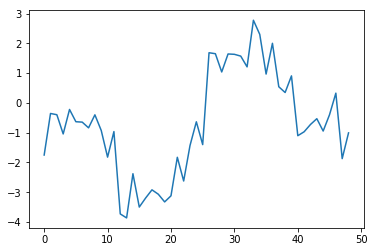

In [6]:
gmmx = linear_gmg.solve(RightF,np.zeros(A1.shape),tol=1e-12)
plt.plot(gmmx)

In [7]:
print("Relative error = {}".format(np.linalg.norm(gmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 2.2834463835146948


Local DMM on fine grid

In [8]:
K = 10
batch_size = 10
num_iter = 4000
step_size = 5e-5
PR_stencil_type = "m3p"
init_point = None
convergence = {}
opt_par_n = {}
conv_time = {}
deep_gmm = dgmg.DeepMG(A1, K=K, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
opt_par = deep_gmm.optimize(num_iter=num_iter, step_size=step_size, batch_size=batch_size, init_point=init_point)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/4000
Upper bound estimation = 0.8453107442319612
Iteration 200/4000
Upper bound estimation = 0.8373407467045346
Iteration 300/4000
Upper bound estimation = 0.8213862052386761
Iteration 400/4000
Upper bound estimation = 0.8116579571113998
Iteration 500/4000
Upper bound estimation = 0.7998027686155791
Iteration 600/4000
Upper bound estimation = 0.7719160462208976
Iteration 700/4000
Upper bound estimation = 0.7679943048722628
Iteration 800/4000
Upper bound estimation = 0.7540613571627635
Iteration 900/4000
Upper bound estimation = 0.7558966149156163
Iteration 1000/4000
Upper bound estimation = 0.7388984536773323
Iteration 1100/4000
Upper bound estimation = 0.7369909763253727
Iteration 1200/4000
Upper bound estimation = 0.7336209960377684
Iteration 1300/4000
Upper bound estimation = 0.7221620478825063
Iteration 1400/4000
Upper bound estimation = 0.7241800121573492
Iteration 1500/4000
Upper bound estimation = 0.7022335015337898
Iteration 1600/4000
Upper bound estimation = 0.69

In [9]:
deep_gmm.update_prd(opt_par)  
current_rho = deep_gmm.compute_rho()
print("Optimized rho = {}".format(current_rho))

Optimized rho = 0.6089095931247149


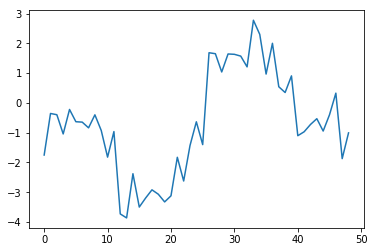

In [10]:
dmmx = deep_gmm.solve(RightF,np.zeros(A1.shape) ,tol=1e-12)
plt.plot(gmmx)

In [11]:
print("Relative error = {}".format(np.linalg.norm(dmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 2.2834463835149683


In [12]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-6,accept_radius = 1 ,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.11955613550773633
L = 0.03
rho = 0.12066023672657897
L = 0.04
rho = 0.12212754525943793
L = 0.05
rho = 0.12383851605054204
L = 0.060000000000000005
rho = 0.1257540101206269
L = 0.07
rho = 0.12785959366534835
L = 0.08
rho = 0.1301397128812768
L = 0.09
rho = 0.13257152904969494
L = 0.09999999999999999
rho = 0.13512799810593978
L = 0.10999999999999999
rho = 0.13778280746968663
L = 0.11999999999999998
rho = 0.14051348861681032
L = 0.12999999999999998
rho = 0.14330228515724572
L = 0.13999999999999999
rho = 0.14613569712548388
L = 0.15
rho = 0.1490035775283909
L = 0.16
rho = 0.15189824655234996
L = 0.17
rho = 0.15481378323654657
L = 0.18000000000000002
rho = 0.157745508402355
L = 0.19000000000000003
rho = 0.1606896235925035
L = 0.20000000000000004
rho = 0.1636429640415551
L = 0.21000000000000005
rho = 0.1666028307729748
L = 0.22000000000000006
rho = 0.16956687623055253
L = 0.23000000000000007
rho = 0.17253302572580984
L = 0.24000000000000007
rho = 0.175

the 33 steps
rho = 0.3584660107160218
the 34 steps
rho = 0.35840532930620983
the 35 steps
rho = 0.35834516862102356
the 36 steps
rho = 0.3582855263659182
the 37 steps
rho = 0.35822640015600854
the 38 steps
rho = 0.3581677875168328
the 39 steps
rho = 0.3581096858852359
the 40 steps
rho = 0.3580520926103437
the 41 steps
rho = 0.35799500495466036
the 42 steps
rho = 0.35793842009525345
the 43 steps
rho = 0.35788233512504547
the 44 steps
rho = 0.3578267470542054
the 45 steps
rho = 0.35777165281162304
the 46 steps
rho = 0.3577170492464937
the 47 steps
rho = 0.35766293312997494
the 48 steps
rho = 0.3576093011569333
the 49 steps
rho = 0.35755614994777435
the 50 steps
rho = 0.35750347605035043
the 51 steps
rho = 0.357451275941937
the 52 steps
rho = 0.3573995460312862
the 53 steps
rho = 0.3573482826607385
the 54 steps
rho = 0.35729748210839835
the 55 steps
rho = 0.35724714059037227
the 56 steps
rho = 0.3571972542630483
the 57 steps
rho = 0.3571478192254358
the 58 steps
rho = 0.357098831521538
th

the 174 steps
rho = 0.35336102320559165
the 175 steps
rho = 0.35333800053272596
the 176 steps
rho = 0.35331505020575305
the 177 steps
rho = 0.35329217109828753
the 178 steps
rho = 0.3532693621084994
the 179 steps
rho = 0.3532466221586562
the 180 steps
rho = 0.3532239501946602
the 181 steps
rho = 0.35320134518560065
the 182 steps
rho = 0.353178806123304
the 183 steps
rho = 0.3531563320218923
the 184 steps
rho = 0.3531339219173475
the 185 steps
rho = 0.3531115748670803
the 186 steps
rho = 0.3530892899495037
the 187 steps
rho = 0.35306706626361495
the 188 steps
rho = 0.3530449029285823
the 189 steps
rho = 0.3530227990833318
the 190 steps
rho = 0.3530007538861518
the 191 steps
rho = 0.35297876651429183
the 192 steps
rho = 0.35295683616357215
the 193 steps
rho = 0.3529349620480015
the 194 steps
rho = 0.3529131433993941
the 195 steps
rho = 0.352891379467
the 196 steps
rho = 0.35286966951713666
the 197 steps
rho = 0.35284801283282624
the 198 steps
rho = 0.35282640871344256
the 199 steps
rho =

the 316 steps
rho = 0.35053596737810594
the 317 steps
rho = 0.35051824938408543
the 318 steps
rho = 0.35050055543190994
the 319 steps
rho = 0.3504828854621393
the 320 steps
rho = 0.35046523941606855
the 321 steps
rho = 0.35044761723570655
the 322 steps
rho = 0.35043001886375647
the 323 steps
rho = 0.35041244424359824
the 324 steps
rho = 0.3503948933192679
the 325 steps
rho = 0.35037736603544095
the 326 steps
rho = 0.3503598623374154
the 327 steps
rho = 0.3503423821710926
the 328 steps
rho = 0.3503249254829621
the 329 steps
rho = 0.3503074922200864
the 330 steps
rho = 0.3502900823300833
the 331 steps
rho = 0.3502726957611118
the 332 steps
rho = 0.3502553324618561
the 333 steps
rho = 0.3502379923815139
the 334 steps
rho = 0.3502206754697782
the 335 steps
rho = 0.35020338167682824
the 336 steps
rho = 0.3501861109533128
the 337 steps
rho = 0.35016886325033714
the 338 steps
rho = 0.35015163851945463
the 339 steps
rho = 0.350134436712649
the 340 steps
rho = 0.350117257782326
the 341 steps
rh

the 456 steps
rho = 0.34826898917642035
the 457 steps
rho = 0.348254218430676
the 458 steps
rho = 0.34823946623810553
the 459 steps
rho = 0.3482247325667308
the 460 steps
rho = 0.3482100173846147
the 461 steps
rho = 0.3481953206598561
the 462 steps
rho = 0.3481806423605955
the 463 steps
rho = 0.34816598245501346
the 464 steps
rho = 0.34815134091132693
the 465 steps
rho = 0.34813671769779403
the 466 steps
rho = 0.3481221127827098
the 467 steps
rho = 0.3481075261344085
the 468 steps
rho = 0.34809295772126336
the 469 steps
rho = 0.3480784075116843
the 470 steps
rho = 0.34806387547412104
the 471 steps
rho = 0.3480493615770601
the 472 steps
rho = 0.34803486578902676
the 473 steps
rho = 0.34802038807858315
the 474 steps
rho = 0.34800592841433015
the 475 steps
rho = 0.3479914867649052
the 476 steps
rho = 0.34797706309898435
the 477 steps
rho = 0.34796265738528
the 478 steps
rho = 0.34794826959254305
the 479 steps
rho = 0.34793389968956057
the 480 steps
rho = 0.34791954764515737
the 481 steps


the 596 steps
rho = 0.3463678729301517
the 597 steps
rho = 0.34635540536381254
the 598 steps
rho = 0.3463429522418742
the 599 steps
rho = 0.34633051353773237
the 600 steps
rho = 0.34631808922482327
the 601 steps
rho = 0.3463056792766238
the 602 steps
rho = 0.34629328366665063
the 603 steps
rho = 0.3462809023684636
the 604 steps
rho = 0.3462685353556614
the 605 steps
rho = 0.3462561826018844
the 606 steps
rho = 0.34624384408081316
the 607 steps
rho = 0.34623151976617045
the 608 steps
rho = 0.346219209631719
the 609 steps
rho = 0.3462069136512624
the 610 steps
rho = 0.34619463179864607
the 611 steps
rho = 0.34618236404775576
the 612 steps
rho = 0.346170110372519
the 613 steps
rho = 0.34615787074690413
the 614 steps
rho = 0.3461456451449192
the 615 steps
rho = 0.3461334335406157
the 616 steps
rho = 0.34612123590808475
the 617 steps
rho = 0.34610905222146027
the 618 steps
rho = 0.34609688245491466
the 619 steps
rho = 0.3460847265826637
the 620 steps
rho = 0.3460725845789654
the 621 steps
r

the 741 steps
rho = 0.3446983658297347
the 742 steps
rho = 0.3446877355549363
the 743 steps
rho = 0.34467711630016423
the 744 steps
rho = 0.3446665080448404
the 745 steps
rho = 0.3446559107684285
the 746 steps
rho = 0.344645324450433
the 747 steps
rho = 0.34463474907039976
the 748 steps
rho = 0.34462418460791505
the 749 steps
rho = 0.3446136310426062
the 750 steps
rho = 0.34460308835414305
the 751 steps
rho = 0.34459255652223414
the 752 steps
rho = 0.3445820355266312
the 753 steps
rho = 0.34457152534712465
the 754 steps
rho = 0.3445610259635483
the 755 steps
rho = 0.3445505373557744
the 756 steps
rho = 0.34454005950371763
the 757 steps
rho = 0.3445295923873325
the 758 steps
rho = 0.3445191359866159
the 759 steps
rho = 0.34450869028160425
the 760 steps
rho = 0.3444982552523743
the 761 steps
rho = 0.34448783087904455
the 762 steps
rho = 0.344477417141775
the 763 steps
rho = 0.34446701402076363
the 764 steps
rho = 0.34445662149625095
the 765 steps
rho = 0.3444462395485182
the 766 steps
rh

the 880 steps
rho = 0.3433180389582898
the 881 steps
rho = 0.34330876068102556
the 882 steps
rho = 0.3432994909443073
the 883 steps
rho = 0.34329022973294976
the 884 steps
rho = 0.34328097703180366
the 885 steps
rho = 0.34327173282575485
the 886 steps
rho = 0.34326249709972495
the 887 steps
rho = 0.34325326983867127
the 888 steps
rho = 0.34324405102758665
the 889 steps
rho = 0.34323484065149895
the 890 steps
rho = 0.3432256386954727
the 891 steps
rho = 0.3432164451446059
the 892 steps
rho = 0.3432072599840325
the 893 steps
rho = 0.3431980831989233
the 894 steps
rho = 0.3431889147744821
the 895 steps
rho = 0.3431797546959487
the 896 steps
rho = 0.34317060294859775
the 897 steps
rho = 0.34316145951773985
the 898 steps
rho = 0.34315232438872006
the 899 steps
rho = 0.3431431975469172
the 900 steps
rho = 0.34313407897774606
the 901 steps
rho = 0.34312496866665687
the 902 steps
rho = 0.343115866599133
the 903 steps
rho = 0.3431067727606946
the 904 steps
rho = 0.3430976871368937
the 905 steps

the 1050 steps
rho = 0.3418523384838239
the 1051 steps
rho = 0.34184432080355387
the 1052 steps
rho = 0.3418363095495213
the 1053 steps
rho = 0.34182830471177883
the 1054 steps
rho = 0.3418203062804043
the 1055 steps
rho = 0.3418123142455011
the 1056 steps
rho = 0.3418043285971987
the 1057 steps
rho = 0.3417963493256515
the 1058 steps
rho = 0.34178837642103876
the 1059 steps
rho = 0.3417804098735657
the 1060 steps
rho = 0.3417724496734621
the 1061 steps
rho = 0.34176449581098467
the 1062 steps
rho = 0.3417565482764124
the 1063 steps
rho = 0.3417486070600514
the 1064 steps
rho = 0.341740672152232
the 1065 steps
rho = 0.34173274354331007
the 1066 steps
rho = 0.34172482122366393
the 1067 steps
rho = 0.34171690518370057
the 1068 steps
rho = 0.34170899541384886
the 1069 steps
rho = 0.34170109190456344
the 1070 steps
rho = 0.3416931946463231
the 1071 steps
rho = 0.3416853036296304
the 1072 steps
rho = 0.3416774188450152
the 1073 steps
rho = 0.3416695402830282
the 1074 steps
rho = 0.341661667

the 1225 steps
rho = 0.3405392377515437
the 1226 steps
rho = 0.3405322133970184
the 1227 steps
rho = 0.3405251940649844
the 1228 steps
rho = 0.34051817974907594
the 1229 steps
rho = 0.3405111704429467
the 1230 steps
rho = 0.3405041661402619
the 1231 steps
rho = 0.3404971668347053
the 1232 steps
rho = 0.3404901725199751
the 1233 steps
rho = 0.3404831831897852
the 1234 steps
rho = 0.340476198837864
the 1235 steps
rho = 0.3404692194579571
the 1236 steps
rho = 0.34046224504382416
the 1237 steps
rho = 0.34045527558924066
the 1238 steps
rho = 0.3404483110879967
the 1239 steps
rho = 0.34044135153389893
the 1240 steps
rho = 0.3404343969207675
the 1241 steps
rho = 0.3404274472424394
the 1242 steps
rho = 0.340420502492765
the 1243 steps
rho = 0.3404135626656109
the 1244 steps
rho = 0.34040662775485875
the 1245 steps
rho = 0.34039969775440404
the 1246 steps
rho = 0.3403927726581575
the 1247 steps
rho = 0.340385852460046
the 1248 steps
rho = 0.3403789371540099
the 1249 steps
rho = 0.34037202673400

the 1363 steps
rho = 0.33961483621506966
the 1364 steps
rho = 0.3396084508669119
the 1365 steps
rho = 0.33960206979201746
the 1366 steps
rho = 0.33959569298577336
the 1367 steps
rho = 0.33958932044357454
the 1368 steps
rho = 0.33958295216082796
the 1369 steps
rho = 0.33957658813295005
the 1370 steps
rho = 0.3395702283553665
the 1371 steps
rho = 0.33956387282351264
the 1372 steps
rho = 0.3395575215328352
the 1373 steps
rho = 0.3395511744787889
the 1374 steps
rho = 0.3395448316568391
the 1375 steps
rho = 0.33953849306246014
the 1376 steps
rho = 0.33953215869113684
the 1377 steps
rho = 0.3395258285383636
the 1378 steps
rho = 0.3395195025996433
the 1379 steps
rho = 0.33951318087048954
the 1380 steps
rho = 0.3395068633464257
the 1381 steps
rho = 0.33950055002298285
the 1382 steps
rho = 0.33949424089570335
the 1383 steps
rho = 0.33948793596013827
the 1384 steps
rho = 0.3394816352118479
the 1385 steps
rho = 0.3394753386464023
the 1386 steps
rho = 0.3394690462593808
the 1387 steps
rho = 0.3394

the 1540 steps
rho = 0.3385473485483931
the 1541 steps
rho = 0.3385416555311899
the 1542 steps
rho = 0.33853596609836123
the 1543 steps
rho = 0.3385302802466059
the 1544 steps
rho = 0.3385245979726304
the 1545 steps
rho = 0.33851891927314465
the 1546 steps
rho = 0.3385132441448644
the 1547 steps
rho = 0.3385075725845105
the 1548 steps
rho = 0.33850190458881
the 1549 steps
rho = 0.3384962401544935
the 1550 steps
rho = 0.33849057927829784
the 1551 steps
rho = 0.338484921956965
the 1552 steps
rho = 0.3384792681872419
the 1553 steps
rho = 0.3384736179658812
the 1554 steps
rho = 0.3384679712896391
the 1555 steps
rho = 0.3384623281552788
the 1556 steps
rho = 0.33845668855956773
the 1557 steps
rho = 0.33845105249927815
the 1558 steps
rho = 0.33844541997118743
the 1559 steps
rho = 0.33843979097207866
the 1560 steps
rho = 0.33843416549873884
the 1561 steps
rho = 0.3384285435479609
the 1562 steps
rho = 0.3384229251165422
the 1563 steps
rho = 0.3384173102012855
the 1564 steps
rho = 0.338411698798

the 1713 steps
rho = 0.3376131565275119
the 1714 steps
rho = 0.3376080384001543
the 1715 steps
rho = 0.33760292335133363
the 1716 steps
rho = 0.33759781137843764
the 1717 steps
rho = 0.3375927024788558
the 1718 steps
rho = 0.3375875966499817
the 1719 steps
rho = 0.3375824938892103
the 1720 steps
rho = 0.3375773941939405
the 1721 steps
rho = 0.33757229756157375
the 1722 steps
rho = 0.33756720398951395
the 1723 steps
rho = 0.33756211347516923
the 1724 steps
rho = 0.3375570260159493
the 1725 steps
rho = 0.33755194160926655
the 1726 steps
rho = 0.3375468602525368
the 1727 steps
rho = 0.3375417819431788
the 1728 steps
rho = 0.33753670667861385
the 1729 steps
rho = 0.33753163445626494
the 1730 steps
rho = 0.33752656527356034
the 1731 steps
rho = 0.3375214991279285
the 1732 steps
rho = 0.3375164360168029
the 1733 steps
rho = 0.3375113759376177
the 1734 steps
rho = 0.33750631888781124
the 1735 steps
rho = 0.33750126486482307
the 1736 steps
rho = 0.3374962138660984
the 1737 steps
rho = 0.337491

the 1877 steps
rho = 0.33681312176660083
the 1878 steps
rho = 0.3368084754458951
the 1879 steps
rho = 0.33680383180815937
the 1880 steps
rho = 0.336799190851155
the 1881 steps
rho = 0.33679455257264485
the 1882 steps
rho = 0.3367899169703947
the 1883 steps
rho = 0.33678528404217045
the 1884 steps
rho = 0.33678065378574085
the 1885 steps
rho = 0.33677602619887625
the 1886 steps
rho = 0.3367714012793485
the 1887 steps
rho = 0.33676677902493146
the 1888 steps
rho = 0.33676215943340027
the 1889 steps
rho = 0.33675754250253276
the 1890 steps
rho = 0.3367529282301076
the 1891 steps
rho = 0.33674831661390625
the 1892 steps
rho = 0.33674370765171063
the 1893 steps
rho = 0.33673910134130564
the 1894 steps
rho = 0.3367344976804768
the 1895 steps
rho = 0.33672989666701264
the 1896 steps
rho = 0.3367252982987021
the 1897 steps
rho = 0.3367207025733368
the 1898 steps
rho = 0.3367161094887094
the 1899 steps
rho = 0.33671151904261504
the 1900 steps
rho = 0.3367069312328496
the 1901 steps
rho = 0.3367

the 2047 steps
rho = 0.3360600433675114
the 2048 steps
rho = 0.33605582231528547
the 2049 steps
rho = 0.33605160358843533
the 2050 steps
rho = 0.3360473871849804
the 2051 steps
rho = 0.33604317310294113
the 2052 steps
rho = 0.33603896134034067
the 2053 steps
rho = 0.33603475189520204
the 2054 steps
rho = 0.3360305447655506
the 2055 steps
rho = 0.3360263399494127
the 2056 steps
rho = 0.33602213744481507
the 2057 steps
rho = 0.33601793724978746
the 2058 steps
rho = 0.3360137393623595
the 2059 steps
rho = 0.33600954378056364
the 2060 steps
rho = 0.33600535050243063
the 2061 steps
rho = 0.33600115952599674
the 2062 steps
rho = 0.3359969708492961
the 2063 steps
rho = 0.3359927844703656
the 2064 steps
rho = 0.3359886003872438
the 2065 steps
rho = 0.33598441859796857
the 2066 steps
rho = 0.33598023910058245
the 2067 steps
rho = 0.33597606189312534
the 2068 steps
rho = 0.3359718869736419
the 2069 steps
rho = 0.3359677143401755
the 2070 steps
rho = 0.3359635439907721
the 2071 steps
rho = 0.3359

the 2225 steps
rho = 0.33534354885280737
the 2226 steps
rho = 0.33533971168485566
the 2227 steps
rho = 0.3353358765093703
the 2228 steps
rho = 0.3353320433245865
the 2229 steps
rho = 0.33532821212874386
the 2230 steps
rho = 0.3353243829200789
the 2231 steps
rho = 0.33532055569683183
the 2232 steps
rho = 0.3353167304572429
the 2233 steps
rho = 0.3353129071995553
the 2234 steps
rho = 0.3353090859220104
the 2235 steps
rho = 0.33530526662285387
the 2236 steps
rho = 0.3353014493003302
the 2237 steps
rho = 0.3352976339526868
the 2238 steps
rho = 0.3352938205781697
the 2239 steps
rho = 0.3352900091750295
the 2240 steps
rho = 0.33528619974151525
the 2241 steps
rho = 0.3352823922758773
the 2242 steps
rho = 0.33527858677636935
the 2243 steps
rho = 0.33527478324124416
the 2244 steps
rho = 0.33527098166875546
the 2245 steps
rho = 0.3352671820571605
the 2246 steps
rho = 0.3352633844047144
the 2247 steps
rho = 0.3352595887096763
the 2248 steps
rho = 0.3352557949703047
the 2249 steps
rho = 0.33525200

the 2392 steps
rho = 0.3347290503099177
the 2393 steps
rho = 0.334725522301785
the 2394 steps
rho = 0.3347219960072612
the 2395 steps
rho = 0.33471847142477185
the 2396 steps
rho = 0.3347149485527423
the 2397 steps
rho = 0.33471142738959775
the 2398 steps
rho = 0.3347079079337672
the 2399 steps
rho = 0.3347043901836792
the 2400 steps
rho = 0.3347008741377633
the 2401 steps
rho = 0.3346973597944499
the 2402 steps
rho = 0.3346938471521719
the 2403 steps
rho = 0.33469033620936234
the 2404 steps
rho = 0.3346868269644552
the 2405 steps
rho = 0.3346833194158865
the 2406 steps
rho = 0.33467981356209187
the 2407 steps
rho = 0.3346763094015096
the 2408 steps
rho = 0.334672806932578
the 2409 steps
rho = 0.3346693061537375
the 2410 steps
rho = 0.33466580706342847
the 2411 steps
rho = 0.3346623096600926
the 2412 steps
rho = 0.3346588139421734
the 2413 steps
rho = 0.3346553199081162
the 2414 steps
rho = 0.3346518275563652
the 2415 steps
rho = 0.3346483368853667
the 2416 steps
rho = 0.33464484789356

the 2567 steps
rho = 0.3341363969269587
the 2568 steps
rho = 0.3341331457806288
the 2569 steps
rho = 0.334129896088955
the 2570 steps
rho = 0.3341266478505547
the 2571 steps
rho = 0.33412340106404376
the 2572 steps
rho = 0.3341201557280431
the 2573 steps
rho = 0.3341169118411713
the 2574 steps
rho = 0.3341136694020497
the 2575 steps
rho = 0.33411042840930083
the 2576 steps
rho = 0.33410718886154683
the 2577 steps
rho = 0.33410395075741234
the 2578 steps
rho = 0.3341007140955231
the 2579 steps
rho = 0.3340974788745055
the 2580 steps
rho = 0.33409424509298574
the 2581 steps
rho = 0.33409101274959374
the 2582 steps
rho = 0.3340877818429587
the 2583 steps
rho = 0.33408455237171125
the 2584 steps
rho = 0.3340813243344837
the 2585 steps
rho = 0.33407809772990815
the 2586 steps
rho = 0.3340748725566187
the 2587 steps
rho = 0.33407164881325124
the 2588 steps
rho = 0.33406842649844104
the 2589 steps
rho = 0.33406520561082553
the 2590 steps
rho = 0.3340619861490431
the 2591 steps
rho = 0.3340587

the 2745 steps
rho = 0.3335793731895275
the 2746 steps
rho = 0.3335763601740929
the 2747 steps
rho = 0.33357334838396446
the 2748 steps
rho = 0.3335703378179482
the 2749 steps
rho = 0.3335673284748509
the 2750 steps
rho = 0.333564320353481
the 2751 steps
rho = 0.33356131345264806
the 2752 steps
rho = 0.33355830777116197
the 2753 steps
rho = 0.3335553033078338
the 2754 steps
rho = 0.333552300061476
the 2755 steps
rho = 0.3335492980309019
the 2756 steps
rho = 0.33354629721492546
the 2757 steps
rho = 0.33354329761236295
the 2758 steps
rho = 0.33354029922202955
the 2759 steps
rho = 0.3335373020427437
the 2760 steps
rho = 0.33353430607332335
the 2761 steps
rho = 0.3335313113125881
the 2762 steps
rho = 0.33352831775935904
the 2763 steps
rho = 0.33352532541245694
the 2764 steps
rho = 0.33352233427070477
the 2765 steps
rho = 0.3335193443329265
the 2766 steps
rho = 0.33351635559794607
the 2767 steps
rho = 0.3335133680645894
the 2768 steps
rho = 0.3335103817316836
the 2769 steps
rho = 0.33350739

the 2919 steps
rho = 0.3330725580984411
the 2920 steps
rho = 0.3330697411972591
the 2921 steps
rho = 0.3330669253289128
the 2922 steps
rho = 0.33306411049238305
the 2923 steps
rho = 0.33306129668665096
the 2924 steps
rho = 0.33305848391069826
the 2925 steps
rho = 0.3330556721635094
the 2926 steps
rho = 0.3330528614440681
the 2927 steps
rho = 0.3330500517513598
the 2928 steps
rho = 0.33304724308437084
the 2929 steps
rho = 0.333044435442088
the 2930 steps
rho = 0.3330416288235002
the 2931 steps
rho = 0.3330388232275958
the 2932 steps
rho = 0.3330360186533647
the 2933 steps
rho = 0.333033215099799
the 2934 steps
rho = 0.33303041256589005
the 2935 steps
rho = 0.33302761105063083
the 2936 steps
rho = 0.3330248105530153
the 2937 steps
rho = 0.3330220110720383
the 2938 steps
rho = 0.33301921260669554
the 2939 steps
rho = 0.3330164151559841
the 2940 steps
rho = 0.33301361871890106
the 2941 steps
rho = 0.33301082329444587
the 2942 steps
rho = 0.33300802888161796
the 2943 steps
rho = 0.333005235

the 3090 steps
rho = 0.3326050779827526
the 3091 steps
rho = 0.3326024236480296
the 3092 steps
rho = 0.3325997701853667
the 3093 steps
rho = 0.33259711759390026
the 3094 steps
rho = 0.33259446587276964
the 3095 steps
rho = 0.3325918150211128
the 3096 steps
rho = 0.3325891650380713
the 3097 steps
rho = 0.3325865159227847
the 3098 steps
rho = 0.3325838676743952
the 3099 steps
rho = 0.3325812202920453
the 3100 steps
rho = 0.33257857377487826
the 3101 steps
rho = 0.3325759281220386
the 3102 steps
rho = 0.33257328333267144
the 3103 steps
rho = 0.33257063940592274
the 3104 steps
rho = 0.33256799634093925
the 3105 steps
rho = 0.33256535413686905
the 3106 steps
rho = 0.3325627127928602
the 3107 steps
rho = 0.3325600723080634
the 3108 steps
rho = 0.33255743268162746
the 3109 steps
rho = 0.3325547939127046
the 3110 steps
rho = 0.33255215600044635
the 3111 steps
rho = 0.3325495189440058
the 3112 steps
rho = 0.3325468827425368
the 3113 steps
rho = 0.33254424739519395
the 3114 steps
rho = 0.3325416

the 3261 steps
rho = 0.33216318501210423
the 3262 steps
rho = 0.3321606679524264
the 3263 steps
rho = 0.3321581516294435
the 3264 steps
rho = 0.3321556360424323
the 3265 steps
rho = 0.33215312119067053
the 3266 steps
rho = 0.3321506070734373
the 3267 steps
rho = 0.33214809369001197
the 3268 steps
rho = 0.3321455810396749
the 3269 steps
rho = 0.33214306912170777
the 3270 steps
rho = 0.33214055793539143
the 3271 steps
rho = 0.3321380474800096
the 3272 steps
rho = 0.332135537754845
the 3273 steps
rho = 0.3321330287591818
the 3274 steps
rho = 0.3321305204923052
the 3275 steps
rho = 0.3321280129535008
the 3276 steps
rho = 0.332125506142055
the 3277 steps
rho = 0.33212300005725404
the 3278 steps
rho = 0.3321204946983876
the 3279 steps
rho = 0.3321179900647434
the 3280 steps
rho = 0.33211548615561115
the 3281 steps
rho = 0.3321129829702806
the 3282 steps
rho = 0.3321104805080436
the 3283 steps
rho = 0.33210797876819137
the 3284 steps
rho = 0.332105477750016
the 3285 steps
rho = 0.332102977452

the 3442 steps
rho = 0.3317189276779648
the 3443 steps
rho = 0.33171653290449743
the 3444 steps
rho = 0.3317141387487876
the 3445 steps
rho = 0.33171174521024027
the 3446 steps
rho = 0.3317093522882622
the 3447 steps
rho = 0.33170695998226035
the 3448 steps
rho = 0.3317045682916427
the 3449 steps
rho = 0.3317021772158174
the 3450 steps
rho = 0.3316997867541944
the 3451 steps
rho = 0.3316973969061826
the 3452 steps
rho = 0.3316950076711933
the 3453 steps
rho = 0.3316926190486361
the 3454 steps
rho = 0.331690231037924
the 3455 steps
rho = 0.3316878436384692
the 3456 steps
rho = 0.3316854568496841
the 3457 steps
rho = 0.33168307067098285
the 3458 steps
rho = 0.33168068510177945
the 3459 steps
rho = 0.3316783001414891
the 3460 steps
rho = 0.3316759157895273
the 3461 steps
rho = 0.33167353204531014
the 3462 steps
rho = 0.3316711489082544
the 3463 steps
rho = 0.3316687663777788
the 3464 steps
rho = 0.33166638445330004
the 3465 steps
rho = 0.33166400313423744
the 3466 steps
rho = 0.3316616224

the 3579 steps
rho = 0.331396358619664
the 3580 steps
rho = 0.3313940432096455
the 3581 steps
rho = 0.3313917283418307
the 3582 steps
rho = 0.33138941401570876
the 3583 steps
rho = 0.33138710023077067
the 3584 steps
rho = 0.3313847869865072
the 3585 steps
rho = 0.33138247428240986
the 3586 steps
rho = 0.33138016211797144
the 3587 steps
rho = 0.33137785049268464
the 3588 steps
rho = 0.3313755394060425
the 3589 steps
rho = 0.33137322885753884
the 3590 steps
rho = 0.33137091884666914
the 3591 steps
rho = 0.3313686093729276
the 3592 steps
rho = 0.33136630043580956
the 3593 steps
rho = 0.33136399203481226
the 3594 steps
rho = 0.3313616841694325
the 3595 steps
rho = 0.33135937683916666
the 3596 steps
rho = 0.3313570700435128
the 3597 steps
rho = 0.3313547637819705
the 3598 steps
rho = 0.33135245805403796
the 3599 steps
rho = 0.33135015285921476
the 3600 steps
rho = 0.3313478481970016
the 3601 steps
rho = 0.3313455440668982
the 3602 steps
rho = 0.33134324046840735
the 3603 steps
rho = 0.33134

the 3717 steps
rho = 0.33108174698276915
the 3718 steps
rho = 0.33107950181284257
the 3719 steps
rho = 0.33107725711991154
the 3720 steps
rho = 0.33107501290353925
the 3721 steps
rho = 0.3310727691632907
the 3722 steps
rho = 0.3310705258987306
the 3723 steps
rho = 0.33106828310942393
the 3724 steps
rho = 0.3310660407949369
the 3725 steps
rho = 0.33106379895483556
the 3726 steps
rho = 0.3310615575886864
the 3727 steps
rho = 0.3310593166960569
the 3728 steps
rho = 0.3310570762765149
the 3729 steps
rho = 0.33105483632962823
the 3730 steps
rho = 0.33105259685496624
the 3731 steps
rho = 0.3310503578520978
the 3732 steps
rho = 0.331048119320593
the 3733 steps
rho = 0.33104588126002144
the 3734 steps
rho = 0.3310436436699542
the 3735 steps
rho = 0.3310414065499624
the 3736 steps
rho = 0.3310391698996174
the 3737 steps
rho = 0.3310369337184918
the 3738 steps
rho = 0.3310346980061585
the 3739 steps
rho = 0.3310324627621901
the 3740 steps
rho = 0.33103022798616005
the 3741 steps
rho = 0.33102799

the 3896 steps
rho = 0.33068707037974815
the 3897 steps
rho = 0.3306849040885687
the 3898 steps
rho = 0.33068273820373995
the 3899 steps
rho = 0.33068057272490536
the 3900 steps
rho = 0.3306784076517097
the 3901 steps
rho = 0.33067624298379916
the 3902 steps
rho = 0.3306740787208194
the 3903 steps
rho = 0.3306719148624158
the 3904 steps
rho = 0.3306697514082366
the 3905 steps
rho = 0.3306675883579279
the 3906 steps
rho = 0.33066542571113733
the 3907 steps
rho = 0.330663263467513
the 3908 steps
rho = 0.33066110162670337
the 3909 steps
rho = 0.33065894018835656
the 3910 steps
rho = 0.3306567791521222
the 3911 steps
rho = 0.3306546185176503
the 3912 steps
rho = 0.33065245828458956
the 3913 steps
rho = 0.33065029845259086
the 3914 steps
rho = 0.3306481390213054
the 3915 steps
rho = 0.33064597999038353
the 3916 steps
rho = 0.3306438213594776
the 3917 steps
rho = 0.330641663128239
the 3918 steps
rho = 0.3306395052963199
the 3919 steps
rho = 0.3306373478633736
the 3920 steps
rho = 0.330635190

the 4032 steps
rho = 0.33039604476396695
the 4033 steps
rho = 0.3303939306354268
the 4034 steps
rho = 0.33039181686846986
the 4035 steps
rho = 0.3303897034627937
the 4036 steps
rho = 0.3303875904180932
the 4037 steps
rho = 0.33038547773406585
the 4038 steps
rho = 0.3303833654104092
the 4039 steps
rho = 0.33038125344681946
the 4040 steps
rho = 0.33037914184299566
the 4041 steps
rho = 0.33037703059863494
the 4042 steps
rho = 0.33037491971343613
the 4043 steps
rho = 0.3303728091870985
the 4044 steps
rho = 0.33037069901932076
the 4045 steps
rho = 0.3303685892098023
the 4046 steps
rho = 0.3303664797582434
the 4047 steps
rho = 0.3303643706643442
the 4048 steps
rho = 0.3303622619278049
the 4049 steps
rho = 0.33036015354832654
the 4050 steps
rho = 0.33035804552561016
the 4051 steps
rho = 0.3303559378593584
the 4052 steps
rho = 0.3303538305492714
the 4053 steps
rho = 0.33035172359505305
the 4054 steps
rho = 0.330349616996405
the 4055 steps
rho = 0.33034751075303004
the 4056 steps
rho = 0.330345

the 4177 steps
rho = 0.3300931257579115
the 4178 steps
rho = 0.33009106105210484
the 4179 steps
rho = 0.3300889966672491
the 4180 steps
rho = 0.33008693260308686
the 4181 steps
rho = 0.3300848688593605
the 4182 steps
rho = 0.3300828054358137
the 4183 steps
rho = 0.3300807423321896
the 4184 steps
rho = 0.3300786795482309
the 4185 steps
rho = 0.3300766170836831
the 4186 steps
rho = 0.33007455493828936
the 4187 steps
rho = 0.3300724931117947
the 4188 steps
rho = 0.33007043160394367
the 4189 steps
rho = 0.33006837041448145
the 4190 steps
rho = 0.3300663095431534
the 4191 steps
rho = 0.3300642489897054
the 4192 steps
rho = 0.330062188753883
the 4193 steps
rho = 0.33006012883543273
the 4194 steps
rho = 0.33005806923410086
the 4195 steps
rho = 0.33005600994963485
the 4196 steps
rho = 0.33005395098178125
the 4197 steps
rho = 0.3300518923302877
the 4198 steps
rho = 0.33004983399490134
the 4199 steps
rho = 0.33004777597537127
the 4200 steps
rho = 0.330045718271445
the 4201 steps
rho = 0.33004366

the 4315 steps
rho = 0.32981112404775936
the 4316 steps
rho = 0.32980910131929353
the 4317 steps
rho = 0.3298070788788613
the 4318 steps
rho = 0.32980505672624166
the 4319 steps
rho = 0.3298030348612162
the 4320 steps
rho = 0.3298010132835639
the 4321 steps
rho = 0.3297989919930662
the 4322 steps
rho = 0.32979697098950245
the 4323 steps
rho = 0.32979495027265443
the 4324 steps
rho = 0.329792929842303
the 4325 steps
rho = 0.3297909096982297
the 4326 steps
rho = 0.32978888984021615
the 4327 steps
rho = 0.3297868702680441
the 4328 steps
rho = 0.32978485098149585
the 4329 steps
rho = 0.3297828319803543
the 4330 steps
rho = 0.3297808132644014
the 4331 steps
rho = 0.3297787948334197
the 4332 steps
rho = 0.3297767766871928
the 4333 steps
rho = 0.32977475882550494
the 4334 steps
rho = 0.3297727412481376
the 4335 steps
rho = 0.3297707239548768
the 4336 steps
rho = 0.3297687069455056
the 4337 steps
rho = 0.3297666902198082
the 4338 steps
rho = 0.3297646737775693
the 4339 steps
rho = 0.3297626576

the 4459 steps
rho = 0.32952271347675605
the 4460 steps
rho = 0.3295207300721314
the 4461 steps
rho = 0.329518746926216
the 4462 steps
rho = 0.3295167640388226
the 4463 steps
rho = 0.3295147814097634
the 4464 steps
rho = 0.3295127990388515
the 4465 steps
rho = 0.3295108169258998
the 4466 steps
rho = 0.3295088350707209
the 4467 steps
rho = 0.3295068534731279
the 4468 steps
rho = 0.32950487213293583
the 4469 steps
rho = 0.32950289104995656
the 4470 steps
rho = 0.3295009102240056
the 4471 steps
rho = 0.3294989296548958
the 4472 steps
rho = 0.32949694934244206
the 4473 steps
rho = 0.3294949692864594
the 4474 steps
rho = 0.32949298948676137
the 4475 steps
rho = 0.3294910099431642
the 4476 steps
rho = 0.32948903065548224
the 4477 steps
rho = 0.3294870516235311
the 4478 steps
rho = 0.32948507284712625
the 4479 steps
rho = 0.32948309432608364
the 4480 steps
rho = 0.32948111606021907
the 4481 steps
rho = 0.32947913804934903
the 4482 steps
rho = 0.32947716029328955
the 4483 steps
rho = 0.3294751

the 4597 steps
rho = 0.3292513716658082
the 4598 steps
rho = 0.3292494222734748
the 4599 steps
rho = 0.3292474731157914
the 4600 steps
rho = 0.32924552419259573
the 4601 steps
rho = 0.32924357550372685
the 4602 steps
rho = 0.329241627049023
the 4603 steps
rho = 0.32923967882832383
the 4604 steps
rho = 0.32923773084146846
the 4605 steps
rho = 0.329235783088296
the 4606 steps
rho = 0.3292338355686458
the 4607 steps
rho = 0.32923188828235744
the 4608 steps
rho = 0.32922994122927096
the 4609 steps
rho = 0.32922799440922684
the 4610 steps
rho = 0.32922604782206427
the 4611 steps
rho = 0.329224101467624
the 4612 steps
rho = 0.32922215534574656
the 4613 steps
rho = 0.3292202094562729
the 4614 steps
rho = 0.3292182637990437
the 4615 steps
rho = 0.3292163183739
the 4616 steps
rho = 0.3292143731806826
the 4617 steps
rho = 0.3292124282192336
the 4618 steps
rho = 0.3292104834893943
the 4619 steps
rho = 0.3292085389910058
the 4620 steps
rho = 0.3292065947239105
the 4621 steps
rho = 0.32920465068795

the 4774 steps
rho = 0.3289098439009447
the 4775 steps
rho = 0.3289079336744537
the 4776 steps
rho = 0.32890602365652855
the 4777 steps
rho = 0.3289041138470355
the 4778 steps
rho = 0.3289022042458397
the 4779 steps
rho = 0.32890029485280814
the 4780 steps
rho = 0.3288983856678078
the 4781 steps
rho = 0.3288964766907041
the 4782 steps
rho = 0.3288945679213646
the 4783 steps
rho = 0.328892659359655
the 4784 steps
rho = 0.32889075100544285
the 4785 steps
rho = 0.3288888428585951
the 4786 steps
rho = 0.3288869349189789
the 4787 steps
rho = 0.32888502718646134
the 4788 steps
rho = 0.32888311966091044
the 4789 steps
rho = 0.3288812123421935
the 4790 steps
rho = 0.32887930523017816
the 4791 steps
rho = 0.32887739832473256
the 4792 steps
rho = 0.32887549162572377
the 4793 steps
rho = 0.3288735851330217
the 4794 steps
rho = 0.32887167884649315
the 4795 steps
rho = 0.3288697727660066
the 4796 steps
rho = 0.328867866891432
the 4797 steps
rho = 0.32886596122263584
the 4798 steps
rho = 0.328864055

the 4911 steps
rho = 0.3286500315532943
the 4912 steps
rho = 0.3286481487071164
the 4913 steps
rho = 0.3286462660523577
the 4914 steps
rho = 0.3286443835889011
the 4915 steps
rho = 0.32864250131663114
the 4916 steps
rho = 0.3286406192354303
the 4917 steps
rho = 0.32863873734518273
the 4918 steps
rho = 0.3286368556457726
the 4919 steps
rho = 0.3286349741370833
the 4920 steps
rho = 0.32863309281899883
the 4921 steps
rho = 0.3286312116914038
the 4922 steps
rho = 0.32862933075418255
the 4923 steps
rho = 0.32862745000721905
the 4924 steps
rho = 0.3286255694503981
the 4925 steps
rho = 0.3286236890836038
the 4926 steps
rho = 0.32862180890672205
the 4927 steps
rho = 0.3286199289196363
the 4928 steps
rho = 0.32861804912223297
the 4929 steps
rho = 0.3286161695143964
the 4930 steps
rho = 0.32861429009601084
the 4931 steps
rho = 0.32861241086696297
the 4932 steps
rho = 0.32861053182713856
the 4933 steps
rho = 0.32860865297642144
the 4934 steps
rho = 0.32860677431469815
the 4935 steps
rho = 0.32860

the 5051 steps
rho = 0.3283882451129168
the 5052 steps
rho = 0.3283863879803553
the 5053 steps
rho = 0.32838453102395093
the 5054 steps
rho = 0.3283826742436033
the 5055 steps
rho = 0.32838081763920907
the 5056 steps
rho = 0.3283789612106676
the 5057 steps
rho = 0.32837710495787725
the 5058 steps
rho = 0.32837524888073744
the 5059 steps
rho = 0.32837339297914603
the 5060 steps
rho = 0.3283715372530022
the 5061 steps
rho = 0.3283696817022044
the 5062 steps
rho = 0.32836782632665273
the 5063 steps
rho = 0.32836597112624544
the 5064 steps
rho = 0.328364116100882
the 5065 steps
rho = 0.32836226125046225
the 5066 steps
rho = 0.32836040657488513
the 5067 steps
rho = 0.3283585520740503
the 5068 steps
rho = 0.32835669774785753
the 5069 steps
rho = 0.3283548435962064
the 5070 steps
rho = 0.3283529896189962
the 5071 steps
rho = 0.3283511358161281
the 5072 steps
rho = 0.32834928218750137
the 5073 steps
rho = 0.32834742873301587
the 5074 steps
rho = 0.3283455754525727
the 5075 steps
rho = 0.328343

the 5195 steps
rho = 0.3281225837872588
the 5196 steps
rho = 0.32812075101955096
the 5197 steps
rho = 0.3281189184142989
the 5198 steps
rho = 0.32811708597141437
the 5199 steps
rho = 0.32811525369080846
the 5200 steps
rho = 0.32811342157239276
the 5201 steps
rho = 0.3281115896160785
the 5202 steps
rho = 0.3281097578217765
the 5203 steps
rho = 0.32810792618939816
the 5204 steps
rho = 0.32810609471885605
the 5205 steps
rho = 0.3281042634100615
the 5206 steps
rho = 0.32810243226292624
the 5207 steps
rho = 0.32810060127736224
the 5208 steps
rho = 0.328098770453281
the 5209 steps
rho = 0.32809693979059507
the 5210 steps
rho = 0.328095109289216
the 5211 steps
rho = 0.3280932789490566
the 5212 steps
rho = 0.3280914487700283
the 5213 steps
rho = 0.3280896187520443
the 5214 steps
rho = 0.32808778889501655
the 5215 steps
rho = 0.3280859591988574
the 5216 steps
rho = 0.3280841296634799
the 5217 steps
rho = 0.3280823002887962
the 5218 steps
rho = 0.3280804710747193
the 5219 steps
rho = 0.328078642

the 5343 steps
rho = 0.32785305582117374
the 5344 steps
rho = 0.3278512461713797
the 5345 steps
rho = 0.327849436671721
the 5346 steps
rho = 0.3278476273221214
the 5347 steps
rho = 0.32784581812250185
the 5348 steps
rho = 0.3278440090727862
the 5349 steps
rho = 0.3278422001728949
the 5350 steps
rho = 0.32784039142275095
the 5351 steps
rho = 0.3278385828222774
the 5352 steps
rho = 0.3278367743713966
the 5353 steps
rho = 0.3278349660700308
the 5354 steps
rho = 0.327833157918103
the 5355 steps
rho = 0.3278313499155355
the 5356 steps
rho = 0.3278295420622519
the 5357 steps
rho = 0.32782773435817375
the 5358 steps
rho = 0.3278259268032255
the 5359 steps
rho = 0.32782411939732903
the 5360 steps
rho = 0.32782231214040847
the 5361 steps
rho = 0.32782050503238575
the 5362 steps
rho = 0.3278186980731846
the 5363 steps
rho = 0.3278168912627291
the 5364 steps
rho = 0.327815084600941
the 5365 steps
rho = 0.3278132780877452
the 5366 steps
rho = 0.3278114717230643
the 5367 steps
rho = 0.3278096655068

the 5491 steps
rho = 0.3275868208663281
the 5492 steps
rho = 0.3275850326239889
the 5493 steps
rho = 0.3275832445209564
the 5494 steps
rho = 0.3275814565571625
the 5495 steps
rho = 0.32757966873253846
the 5496 steps
rho = 0.3275778810470163
the 5497 steps
rho = 0.32757609350052647
the 5498 steps
rho = 0.32757430609300114
the 5499 steps
rho = 0.32757251882437155
the 5500 steps
rho = 0.3275707316945697
the 5501 steps
rho = 0.3275689447035268
the 5502 steps
rho = 0.32756715785117596
the 5503 steps
rho = 0.32756537113744705
the 5504 steps
rho = 0.3275635845622735
the 5505 steps
rho = 0.32756179812558617
the 5506 steps
rho = 0.3275600118273179
the 5507 steps
rho = 0.32755822566740045
the 5508 steps
rho = 0.327556439645766
the 5509 steps
rho = 0.32755465376234627
the 5510 steps
rho = 0.32755286801707395
the 5511 steps
rho = 0.3275510824098815
the 5512 steps
rho = 0.32754929694070095
the 5513 steps
rho = 0.32754751160946405
the 5514 steps
rho = 0.3275457264161043
the 5515 steps
rho = 0.327543

the 5640 steps
rho = 0.3273218727336862
the 5641 steps
rho = 0.32732010452021293
the 5642 steps
rho = 0.32731833643640346
the 5643 steps
rho = 0.327316568482198
the 5644 steps
rho = 0.32731480065753527
the 5645 steps
rho = 0.3273130329623544
the 5646 steps
rho = 0.32731126539659455
the 5647 steps
rho = 0.32730949796019476
the 5648 steps
rho = 0.3273077306530953
the 5649 steps
rho = 0.3273059634752344
the 5650 steps
rho = 0.32730419642655234
the 5651 steps
rho = 0.32730242950698785
the 5652 steps
rho = 0.3273006627164807
the 5653 steps
rho = 0.3272988960549707
the 5654 steps
rho = 0.3272971295223969
the 5655 steps
rho = 0.3272953631187001
the 5656 steps
rho = 0.32729359684381887
the 5657 steps
rho = 0.32729183069769296
the 5658 steps
rho = 0.32729006468026284
the 5659 steps
rho = 0.3272882987914683
the 5660 steps
rho = 0.32728653303124805
the 5661 steps
rho = 0.32728476739954304
the 5662 steps
rho = 0.32728300189629345
the 5663 steps
rho = 0.32728123652143876
the 5664 steps
rho = 0.3272

the 5786 steps
rho = 0.3270650559489323
the 5787 steps
rho = 0.32706330604484096
the 5788 steps
rho = 0.32706155626199773
the 5789 steps
rho = 0.3270598066003463
the 5790 steps
rho = 0.3270580570598337
the 5791 steps
rho = 0.32705630764040533
the 5792 steps
rho = 0.32705455834200603
the 5793 steps
rho = 0.3270528091645817
the 5794 steps
rho = 0.3270510601080788
the 5795 steps
rho = 0.3270493111724422
the 5796 steps
rho = 0.32704756235761806
the 5797 steps
rho = 0.32704581366355207
the 5798 steps
rho = 0.3270440650901898
the 5799 steps
rho = 0.3270423166374776
the 5800 steps
rho = 0.32704056830536166
the 5801 steps
rho = 0.32703882009378676
the 5802 steps
rho = 0.3270370720027008
the 5803 steps
rho = 0.3270353240320484
the 5804 steps
rho = 0.3270335761817752
the 5805 steps
rho = 0.3270318284518287
the 5806 steps
rho = 0.3270300808421542
the 5807 steps
rho = 0.32702833335269815
the 5808 steps
rho = 0.32702658598340706
the 5809 steps
rho = 0.32702483873422733
the 5810 steps
rho = 0.327023

the 5966 steps
rho = 0.3267519760469241
the 5967 steps
rho = 0.32675024712599676
the 5968 steps
rho = 0.32674851831711643
the 5969 steps
rho = 0.3267467896202334
the 5970 steps
rho = 0.32674506103530127
the 5971 steps
rho = 0.3267433325622718
the 5972 steps
rho = 0.3267416042010958
the 5973 steps
rho = 0.32673987595172765
the 5974 steps
rho = 0.32673814781411875
the 5975 steps
rho = 0.32673641978822127
the 5976 steps
rho = 0.3267346918739872
the 5977 steps
rho = 0.32673296407136915
the 5978 steps
rho = 0.3267312363803205
the 5979 steps
rho = 0.3267295088007923
the 5980 steps
rho = 0.3267277813327372
the 5981 steps
rho = 0.32672605397610865
the 5982 steps
rho = 0.3267243267308581
the 5983 steps
rho = 0.32672259959693895
the 5984 steps
rho = 0.32672087257430316
the 5985 steps
rho = 0.32671914566290383
the 5986 steps
rho = 0.32671741886269323
the 5987 steps
rho = 0.3267156921736246
the 5988 steps
rho = 0.3267139655956498
the 5989 steps
rho = 0.3267122391287222
the 5990 steps
rho = 0.32671

the 6108 steps
rho = 0.32650756911561407
the 6109 steps
rho = 0.32650585564070583
the 6110 steps
rho = 0.32650414227135954
the 6111 steps
rho = 0.3265024290075319
the 6112 steps
rho = 0.3265007158491795
the 6113 steps
rho = 0.3264990027962584
the 6114 steps
rho = 0.32649728984872567
the 6115 steps
rho = 0.3264955770065374
the 6116 steps
rho = 0.32649386426965105
the 6117 steps
rho = 0.3264921516380228
the 6118 steps
rho = 0.32649043911160935
the 6119 steps
rho = 0.3264887266903674
the 6120 steps
rho = 0.32648701437425354
the 6121 steps
rho = 0.32648530216322513
the 6122 steps
rho = 0.32648359005723865
the 6123 steps
rho = 0.326481878056251
the 6124 steps
rho = 0.3264801661602189
the 6125 steps
rho = 0.32647845436909945
the 6126 steps
rho = 0.32647674268284915
the 6127 steps
rho = 0.32647503110142595
the 6128 steps
rho = 0.3264733196247857
the 6129 steps
rho = 0.3264716082528861
the 6130 steps
rho = 0.32646989698568374
the 6131 steps
rho = 0.326468185823136
the 6132 steps
rho = 0.326466

the 6250 steps
rho = 0.32626529259418674
the 6251 steps
rho = 0.3262635936866475
the 6252 steps
rho = 0.32626189487876905
the 6253 steps
rho = 0.32626019617051283
the 6254 steps
rho = 0.32625849756183817
the 6255 steps
rho = 0.3262567990527057
the 6256 steps
rho = 0.32625510064307534
the 6257 steps
rho = 0.32625340233290884
the 6258 steps
rho = 0.32625170412216536
the 6259 steps
rho = 0.32625000601080606
the 6260 steps
rho = 0.32624830799879134
the 6261 steps
rho = 0.32624661008608163
the 6262 steps
rho = 0.32624491227263747
the 6263 steps
rho = 0.3262432145584194
the 6264 steps
rho = 0.3262415169433883
the 6265 steps
rho = 0.3262398194275047
the 6266 steps
rho = 0.32623812201072855
the 6267 steps
rho = 0.3262364246930217
the 6268 steps
rho = 0.3262347274743443
the 6269 steps
rho = 0.32623303035465684
the 6270 steps
rho = 0.32623133333392007
the 6271 steps
rho = 0.3262296364120954
the 6272 steps
rho = 0.326227939589143
the 6273 steps
rho = 0.326226242865024
the 6274 steps
rho = 0.32622

the 6423 steps
rho = 0.3259728315844143
the 6424 steps
rho = 0.32597114934854654
the 6425 steps
rho = 0.3259694672058315
the 6426 steps
rho = 0.325967785156234
the 6427 steps
rho = 0.32596610319971897
the 6428 steps
rho = 0.32596442133625086
the 6429 steps
rho = 0.3259627395657936
the 6430 steps
rho = 0.32596105788831164
the 6431 steps
rho = 0.32595937630376953
the 6432 steps
rho = 0.3259576948121319
the 6433 steps
rho = 0.3259560134133632
the 6434 steps
rho = 0.32595433210742775
the 6435 steps
rho = 0.3259526508942906
the 6436 steps
rho = 0.32595096977391563
the 6437 steps
rho = 0.32594928874626794
the 6438 steps
rho = 0.3259476078113119
the 6439 steps
rho = 0.3259459269690127
the 6440 steps
rho = 0.32594424621933427
the 6441 steps
rho = 0.32594256556224166
the 6442 steps
rho = 0.3259408849976994
the 6443 steps
rho = 0.3259392045256724
the 6444 steps
rho = 0.32593752414612503
the 6445 steps
rho = 0.325935843859023
the 6446 steps
rho = 0.32593416366433015
the 6447 steps
rho = 0.3259324

the 6595 steps
rho = 0.3256848279649102
the 6596 steps
rho = 0.32568316124461044
the 6597 steps
rho = 0.3256814946116362
the 6598 steps
rho = 0.3256798280659544
the 6599 steps
rho = 0.3256781616075339
the 6600 steps
rho = 0.3256764952363422
the 6601 steps
rho = 0.32567482895234656
the 6602 steps
rho = 0.32567316275551605
the 6603 steps
rho = 0.32567149664581746
the 6604 steps
rho = 0.32566983062321947
the 6605 steps
rho = 0.3256681646876898
the 6606 steps
rho = 0.32566649883919635
the 6607 steps
rho = 0.32566483307770716
the 6608 steps
rho = 0.32566316740318957
the 6609 steps
rho = 0.3256615018156127
the 6610 steps
rho = 0.32565983631494405
the 6611 steps
rho = 0.3256581709011517
the 6612 steps
rho = 0.32565650557420384
the 6613 steps
rho = 0.3256548403340683
the 6614 steps
rho = 0.3256531751807134
the 6615 steps
rho = 0.3256515101141071
the 6616 steps
rho = 0.3256498451342176
the 6617 steps
rho = 0.32564818024101316
the 6618 steps
rho = 0.3256465154344625
the 6619 steps
rho = 0.325644

the 6768 steps
rho = 0.32539775793745124
the 6769 steps
rho = 0.32539610586086903
the 6770 steps
rho = 0.3253944538663102
the 6771 steps
rho = 0.3253928019537449
the 6772 steps
rho = 0.3253911501231445
the 6773 steps
rho = 0.3253894983744799
the 6774 steps
rho = 0.32538784670772164
the 6775 steps
rho = 0.32538619512284045
the 6776 steps
rho = 0.32538454361980795
the 6777 steps
rho = 0.3253828921985941
the 6778 steps
rho = 0.3253812408591712
the 6779 steps
rho = 0.3253795896015092
the 6780 steps
rho = 0.32537793842557955
the 6781 steps
rho = 0.325376287331353
the 6782 steps
rho = 0.3253746363188009
the 6783 steps
rho = 0.3253729853878939
the 6784 steps
rho = 0.3253713345386029
the 6785 steps
rho = 0.32536968377089975
the 6786 steps
rho = 0.3253680330847543
the 6787 steps
rho = 0.3253663824801395
the 6788 steps
rho = 0.3253647319570248
the 6789 steps
rho = 0.325363081515382
the 6790 steps
rho = 0.3253614311551819
the 6791 steps
rho = 0.32535978087639666
the 6792 steps
rho = 0.32535813067

the 6943 steps
rho = 0.325109868341565
the 6944 steps
rho = 0.3251082301890714
the 6945 steps
rho = 0.3251065921137385
the 6946 steps
rho = 0.3251049541155399
the 6947 steps
rho = 0.3251033161944488
the 6948 steps
rho = 0.3251016783504388
the 6949 steps
rho = 0.3251000405834839
the 6950 steps
rho = 0.32509840289355696
the 6951 steps
rho = 0.3250967652806321
the 6952 steps
rho = 0.3250951277446827
the 6953 steps
rho = 0.32509349028568263
the 6954 steps
rho = 0.32509185290360526
the 6955 steps
rho = 0.32509021559842477
the 6956 steps
rho = 0.3250885783701146
the 6957 steps
rho = 0.32508694121864823
the 6958 steps
rho = 0.3250853041439997
the 6959 steps
rho = 0.32508366714614273
the 6960 steps
rho = 0.3250820302250508
the 6961 steps
rho = 0.3250803933806976
the 6962 steps
rho = 0.32507875661305685
the 6963 steps
rho = 0.3250771199221036
the 6964 steps
rho = 0.32507548330780967
the 6965 steps
rho = 0.32507384677015067
the 6966 steps
rho = 0.3250722103090995
the 6967 steps
rho = 0.325070573

the 7120 steps
rho = 0.3248210937276247
the 7121 steps
rho = 0.324819468833332
the 7122 steps
rho = 0.32481784401173563
the 7123 steps
rho = 0.3248162192628112
the 7124 steps
rho = 0.3248145945865353
the 7125 steps
rho = 0.3248129699828836
the 7126 steps
rho = 0.32481134545183143
the 7127 steps
rho = 0.3248097209933567
the 7128 steps
rho = 0.32480809660743315
the 7129 steps
rho = 0.32480647229403875
the 7130 steps
rho = 0.3248048480531488
the 7131 steps
rho = 0.3248032238847387
the 7132 steps
rho = 0.32480159978878537
the 7133 steps
rho = 0.32479997576526487
the 7134 steps
rho = 0.32479835181415345
the 7135 steps
rho = 0.3247967279354266
the 7136 steps
rho = 0.32479510412906126
the 7137 steps
rho = 0.3247934803950325
the 7138 steps
rho = 0.3247918567333176
the 7139 steps
rho = 0.3247902331438925
the 7140 steps
rho = 0.32478860962673334
the 7141 steps
rho = 0.32478698618181595
the 7142 steps
rho = 0.32478536280911685
the 7143 steps
rho = 0.32478373950861245
the 7144 steps
rho = 0.324782

the 7257 steps
rho = 0.32459915055682104
the 7258 steps
rho = 0.32459753540346387
the 7259 steps
rho = 0.3245959203196299
the 7260 steps
rho = 0.3245943053052965
the 7261 steps
rho = 0.3245926903604415
the 7262 steps
rho = 0.3245910754850429
the 7263 steps
rho = 0.3245894606790778
the 7264 steps
rho = 0.3245878459425243
the 7265 steps
rho = 0.3245862312753609
the 7266 steps
rho = 0.3245846166775638
the 7267 steps
rho = 0.3245830021491119
the 7268 steps
rho = 0.3245813876899829
the 7269 steps
rho = 0.3245797733001542
the 7270 steps
rho = 0.3245781589796035
the 7271 steps
rho = 0.3245765447283091
the 7272 steps
rho = 0.3245749305462485
the 7273 steps
rho = 0.3245733164333993
the 7274 steps
rho = 0.324571702389741
the 7275 steps
rho = 0.32457008841524904
the 7276 steps
rho = 0.3245684745099027
the 7277 steps
rho = 0.3245668606736798
the 7278 steps
rho = 0.3245652469065581
the 7279 steps
rho = 0.32456363320851517
the 7280 steps
rho = 0.32456201957952946
the 7281 steps
rho = 0.3245604060195

the 7432 steps
rho = 0.32431753806086644
the 7433 steps
rho = 0.32431593474458587
the 7434 steps
rho = 0.3243143314941001
the 7435 steps
rho = 0.3243127283093885
the 7436 steps
rho = 0.32431112519043087
the 7437 steps
rho = 0.32430952213720743
the 7438 steps
rho = 0.324307919149697
the 7439 steps
rho = 0.3243063162278802
the 7440 steps
rho = 0.32430471337173605
the 7441 steps
rho = 0.3243031105812446
the 7442 steps
rho = 0.3243015078563857
the 7443 steps
rho = 0.3242999051971389
the 7444 steps
rho = 0.32429830260348486
the 7445 steps
rho = 0.3242967000754016
the 7446 steps
rho = 0.3242950976128702
the 7447 steps
rho = 0.3242934952158702
the 7448 steps
rho = 0.32429189288438154
the 7449 steps
rho = 0.3242902906183834
the 7450 steps
rho = 0.3242886884178571
the 7451 steps
rho = 0.32428708628278075
the 7452 steps
rho = 0.3242854842131353
the 7453 steps
rho = 0.32428388220890053
the 7454 steps
rho = 0.32428228027005596
the 7455 steps
rho = 0.3242806783965818
the 7456 steps
rho = 0.32427907

the 7568 steps
rho = 0.32410008285644676
the 7569 steps
rho = 0.32409848830609056
the 7570 steps
rho = 0.3240968938188638
the 7571 steps
rho = 0.32409529939474674
the 7572 steps
rho = 0.3240937050337205
the 7573 steps
rho = 0.3240921107357661
the 7574 steps
rho = 0.32409051650086473
the 7575 steps
rho = 0.32408892232899766
the 7576 steps
rho = 0.324087328220146
the 7577 steps
rho = 0.32408573417429104
the 7578 steps
rho = 0.32408414019141374
the 7579 steps
rho = 0.3240825462714954
the 7580 steps
rho = 0.32408095241451734
the 7581 steps
rho = 0.32407935862046056
the 7582 steps
rho = 0.32407776488930623
the 7583 steps
rho = 0.32407617122103566
the 7584 steps
rho = 0.3240745776156298
the 7585 steps
rho = 0.3240729840730707
the 7586 steps
rho = 0.32407139059333867
the 7587 steps
rho = 0.3240697971764158
the 7588 steps
rho = 0.32406820382228285
the 7589 steps
rho = 0.32406661053092123
the 7590 steps
rho = 0.32406501730231246
the 7591 steps
rho = 0.32406342413643785
the 7592 steps
rho = 0.32

the 7706 steps
rho = 0.32388062370885684
the 7707 steps
rho = 0.3238790376958824
the 7708 steps
rho = 0.32387745174352206
the 7709 steps
rho = 0.32387586585175815
the 7710 steps
rho = 0.3238742800205733
the 7711 steps
rho = 0.3238726942499499
the 7712 steps
rho = 0.3238711085398707
the 7713 steps
rho = 0.3238695228903184
the 7714 steps
rho = 0.32386793730127494
the 7715 steps
rho = 0.32386635177272327
the 7716 steps
rho = 0.3238647663046448
the 7717 steps
rho = 0.3238631808970239
the 7718 steps
rho = 0.3238615955498414
the 7719 steps
rho = 0.32386001026308114
the 7720 steps
rho = 0.32385842503672446
the 7721 steps
rho = 0.32385683987075486
the 7722 steps
rho = 0.3238552547651551
the 7723 steps
rho = 0.32385366971990653
the 7724 steps
rho = 0.32385208473499255
the 7725 steps
rho = 0.323850499810396
the 7726 steps
rho = 0.323848914946099
the 7727 steps
rho = 0.3238473301420839
the 7728 steps
rho = 0.3238457453983345
the 7729 steps
rho = 0.323844160714832
the 7730 steps
rho = 0.3238425760

the 7844 steps
rho = 0.3236623195168453
the 7845 steps
rho = 0.3236607417066699
the 7846 steps
rho = 0.3236591639547732
the 7847 steps
rho = 0.32365758626113844
the 7848 steps
rho = 0.3236560086257506
the 7849 steps
rho = 0.3236544310485923
the 7850 steps
rho = 0.32365285352964773
the 7851 steps
rho = 0.3236512760689002
the 7852 steps
rho = 0.32364969866633436
the 7853 steps
rho = 0.3236481213219336
the 7854 steps
rho = 0.3236465440356812
the 7855 steps
rho = 0.3236449668075609
the 7856 steps
rho = 0.32364338963755734
the 7857 steps
rho = 0.32364181252565344
the 7858 steps
rho = 0.32364023547183346
the 7859 steps
rho = 0.3236386584760811
the 7860 steps
rho = 0.3236370815383801
the 7861 steps
rho = 0.3236355046587139
the 7862 steps
rho = 0.3236339278370672
the 7863 steps
rho = 0.3236323510734236
the 7864 steps
rho = 0.32363077436776627
the 7865 steps
rho = 0.32362919772007986
the 7866 steps
rho = 0.3236276211303478
the 7867 steps
rho = 0.32362604459855443
the 7868 steps
rho = 0.32362446

the 8021 steps
rho = 0.3233839403965213
the 8022 steps
rho = 0.32338237265559344
the 8023 steps
rho = 0.3233808049701916
the 8024 steps
rho = 0.32337923734030105
the 8025 steps
rho = 0.3233776697659072
the 8026 steps
rho = 0.32337610224699537
the 8027 steps
rho = 0.32337453478355027
the 8028 steps
rho = 0.32337296737555704
the 8029 steps
rho = 0.3233714000230026
the 8030 steps
rho = 0.32336983272586955
the 8031 steps
rho = 0.32336826548414493
the 8032 steps
rho = 0.3233666982978134
the 8033 steps
rho = 0.32336513116686044
the 8034 steps
rho = 0.32336356409127087
the 8035 steps
rho = 0.32336199707103075
the 8036 steps
rho = 0.3233604301061248
the 8037 steps
rho = 0.3233588631965384
the 8038 steps
rho = 0.32335729634225663
the 8039 steps
rho = 0.32335572954326497
the 8040 steps
rho = 0.3233541627995489
the 8041 steps
rho = 0.3233525961110934
the 8042 steps
rho = 0.32335102947788397
the 8043 steps
rho = 0.3233494628999065
the 8044 steps
rho = 0.3233478963771455
the 8045 steps
rho = 0.3233

the 8195 steps
rho = 0.3231119767066245
the 8196 steps
rho = 0.3231104184110491
the 8197 steps
rho = 0.32310886016854046
the 8198 steps
rho = 0.32310730197908333
the 8199 steps
rho = 0.3231057438426653
the 8200 steps
rho = 0.3231041857592719
the 8201 steps
rho = 0.3231026277288908
the 8202 steps
rho = 0.3231010697515082
the 8203 steps
rho = 0.32309951182711066
the 8204 steps
rho = 0.32309795395568425
the 8205 steps
rho = 0.3230963961372161
the 8206 steps
rho = 0.32309483837169284
the 8207 steps
rho = 0.3230932806591007
the 8208 steps
rho = 0.3230917229994267
the 8209 steps
rho = 0.3230901653926567
the 8210 steps
rho = 0.323088607838778
the 8211 steps
rho = 0.3230870503377772
the 8212 steps
rho = 0.3230854928896398
the 8213 steps
rho = 0.32308393549435405
the 8214 steps
rho = 0.3230823781519063
the 8215 steps
rho = 0.32308082086228224
the 8216 steps
rho = 0.32307926362546957
the 8217 steps
rho = 0.32307770644145406
the 8218 steps
rho = 0.32307614931022277
the 8219 steps
rho = 0.32307459

the 8374 steps
rho = 0.32283387482046855
the 8375 steps
rho = 0.3228323258157288
the 8376 steps
rho = 0.3228307768617566
the 8377 steps
rho = 0.3228292279585387
the 8378 steps
rho = 0.3228276791060646
the 8379 steps
rho = 0.322826130304321
the 8380 steps
rho = 0.3228245815532959
the 8381 steps
rho = 0.32282303285297703
the 8382 steps
rho = 0.3228214842033521
the 8383 steps
rho = 0.3228199356044096
the 8384 steps
rho = 0.3228183870561371
the 8385 steps
rho = 0.322816838558522
the 8386 steps
rho = 0.3228152901115521
the 8387 steps
rho = 0.3228137417152161
the 8388 steps
rho = 0.32281219336950095
the 8389 steps
rho = 0.3228106450743957
the 8390 steps
rho = 0.32280909682988596
the 8391 steps
rho = 0.32280754863596245
the 8392 steps
rho = 0.3228060004926111
the 8393 steps
rho = 0.32280445239982003
the 8394 steps
rho = 0.32280290435757814
the 8395 steps
rho = 0.32280135636587226
the 8396 steps
rho = 0.32279980842469097
the 8397 steps
rho = 0.3227982605340218
the 8398 steps
rho = 0.3227967126

the 8548 steps
rho = 0.3225651018006185
the 8549 steps
rho = 0.32256356145127607
the 8550 steps
rho = 0.32256202115067484
the 8551 steps
rho = 0.3225604808988034
the 8552 steps
rho = 0.32255894069565116
the 8553 steps
rho = 0.32255740054120646
the 8554 steps
rho = 0.3225558604354586
the 8555 steps
rho = 0.3225543203783965
the 8556 steps
rho = 0.32255278037000823
the 8557 steps
rho = 0.3225512404102844
the 8558 steps
rho = 0.32254970049921294
the 8559 steps
rho = 0.3225481606367823
the 8560 steps
rho = 0.3225466208229823
the 8561 steps
rho = 0.3225450810578026
the 8562 steps
rho = 0.32254354134123053
the 8563 steps
rho = 0.3225420016732559
the 8564 steps
rho = 0.32254046205386744
the 8565 steps
rho = 0.32253892248305494
the 8566 steps
rho = 0.3225373829608064
the 8567 steps
rho = 0.3225358434871117
the 8568 steps
rho = 0.32253430406195854
the 8569 steps
rho = 0.3225327646853378
the 8570 steps
rho = 0.3225312253572368
the 8571 steps
rho = 0.3225296860776458
the 8572 steps
rho = 0.3225281

the 8725 steps
rho = 0.32229320932516187
the 8726 steps
rho = 0.32229167743581794
the 8727 steps
rho = 0.3222901455933465
the 8728 steps
rho = 0.32228861379773777
the 8729 steps
rho = 0.32228708204898215
the 8730 steps
rho = 0.3222855503470686
the 8731 steps
rho = 0.32228401869198814
the 8732 steps
rho = 0.3222824870837301
the 8733 steps
rho = 0.3222809555222842
the 8734 steps
rho = 0.3222794240076412
the 8735 steps
rho = 0.32227789253979094
the 8736 steps
rho = 0.3222763611187231
the 8737 steps
rho = 0.32227482974442767
the 8738 steps
rho = 0.3222732984168953
the 8739 steps
rho = 0.3222717671361154
the 8740 steps
rho = 0.3222702359020779
the 8741 steps
rho = 0.32226870471477304
the 8742 steps
rho = 0.3222671735741916
the 8743 steps
rho = 0.32226564248032297
the 8744 steps
rho = 0.32226411143315686
the 8745 steps
rho = 0.32226258043268324
the 8746 steps
rho = 0.3222610494788933
the 8747 steps
rho = 0.3222595185717765
the 8748 steps
rho = 0.3222579877113226
the 8749 steps
rho = 0.322256

the 8897 steps
rho = 0.32203040550367307
the 8898 steps
rho = 0.32202888153352754
the 8899 steps
rho = 0.322027357608611
the 8900 steps
rho = 0.3220258337289133
the 8901 steps
rho = 0.3220243098944261
the 8902 steps
rho = 0.32202278610513985
the 8903 steps
rho = 0.322021262361046
the 8904 steps
rho = 0.32201973866213457
the 8905 steps
rho = 0.3220182150083977
the 8906 steps
rho = 0.3220166913998254
the 8907 steps
rho = 0.32201516783640866
the 8908 steps
rho = 0.3220136443181393
the 8909 steps
rho = 0.3220121208450069
the 8910 steps
rho = 0.3220105974170035
the 8911 steps
rho = 0.32200907403411977
the 8912 steps
rho = 0.322007550696346
the 8913 steps
rho = 0.32200602740367473
the 8914 steps
rho = 0.3220045041560954
the 8915 steps
rho = 0.3220029809536
the 8916 steps
rho = 0.32200145779617906
the 8917 steps
rho = 0.3219999346838235
the 8918 steps
rho = 0.3219984116165246
the 8919 steps
rho = 0.32199688859427344
the 8920 steps
rho = 0.32199536561706016
the 8921 steps
rho = 0.3219938426848

the 9073 steps
rho = 0.32176287535206266
the 9074 steps
rho = 0.3217613592066555
the 9075 steps
rho = 0.32175984310495415
the 9076 steps
rho = 0.3217583270469517
the 9077 steps
rho = 0.3217568110326391
the 9078 steps
rho = 0.32175529506200745
the 9079 steps
rho = 0.3217537791350501
the 9080 steps
rho = 0.32175226325175804
the 9081 steps
rho = 0.3217507474121229
the 9082 steps
rho = 0.32174923161613667
the 9083 steps
rho = 0.3217477158637913
the 9084 steps
rho = 0.32174620015507877
the 9085 steps
rho = 0.3217446844899907
the 9086 steps
rho = 0.32174316886851884
the 9087 steps
rho = 0.3217416532906548
the 9088 steps
rho = 0.32174013775639126
the 9089 steps
rho = 0.3217386222657193
the 9090 steps
rho = 0.3217371068186308
the 9091 steps
rho = 0.32173559141511815
the 9092 steps
rho = 0.32173407605517285
the 9093 steps
rho = 0.3217325607387871
the 9094 steps
rho = 0.32173104546595244
the 9095 steps
rho = 0.3217295302366605
the 9096 steps
rho = 0.3217280150509034
the 9097 steps
rho = 0.321726

the 9216 steps
rho = 0.32154650647077554
the 9217 steps
rho = 0.3215449964942736
the 9218 steps
rho = 0.32154348656035137
the 9219 steps
rho = 0.3215419766690022
the 9220 steps
rho = 0.32154046682021803
the 9221 steps
rho = 0.3215389570139908
the 9222 steps
rho = 0.32153744725031347
the 9223 steps
rho = 0.3215359375291782
the 9224 steps
rho = 0.3215344278505789
the 9225 steps
rho = 0.32153291821450597
the 9226 steps
rho = 0.32153140862095236
the 9227 steps
rho = 0.32152989906991175
the 9228 steps
rho = 0.3215283895613758
the 9229 steps
rho = 0.3215268800953372
the 9230 steps
rho = 0.3215253706717882
the 9231 steps
rho = 0.3215238612907212
the 9232 steps
rho = 0.321522351952129
the 9233 steps
rho = 0.3215208426560041
the 9234 steps
rho = 0.32151933340233924
the 9235 steps
rho = 0.3215178241911264
the 9236 steps
rho = 0.3215163150223591
the 9237 steps
rho = 0.3215148058960287
the 9238 steps
rho = 0.3215132968121281
the 9239 steps
rho = 0.32151178777065026
the 9240 steps
rho = 0.321510278

the 9395 steps
rho = 0.32127689210851335
the 9396 steps
rho = 0.32127538963774044
the 9397 steps
rho = 0.3212738872082665
the 9398 steps
rho = 0.32127238482008424
the 9399 steps
rho = 0.32127088247318664
the 9400 steps
rho = 0.3212693801675682
the 9401 steps
rho = 0.3212678779032209
the 9402 steps
rho = 0.3212663756801388
the 9403 steps
rho = 0.32126487349831395
the 9404 steps
rho = 0.3212633713577414
the 9405 steps
rho = 0.32126186925841294
the 9406 steps
rho = 0.32126036720032203
the 9407 steps
rho = 0.3212588651834627
the 9408 steps
rho = 0.32125736320782694
the 9409 steps
rho = 0.3212558612734096
the 9410 steps
rho = 0.3212543593802024
the 9411 steps
rho = 0.3212528575282001
the 9412 steps
rho = 0.32125135571739494
the 9413 steps
rho = 0.3212498539477804
the 9414 steps
rho = 0.3212483522193502
the 9415 steps
rho = 0.32124685053209684
the 9416 steps
rho = 0.3212453488860142
the 9417 steps
rho = 0.3212438472810955
the 9418 steps
rho = 0.321242345717334
the 9419 steps
rho = 0.32124084

the 9535 steps
rho = 0.32106694506494715
the 9536 steps
rho = 0.3210654483118502
the 9537 steps
rho = 0.32106395159914136
the 9538 steps
rho = 0.32106245492681584
the 9539 steps
rho = 0.3210609582948657
the 9540 steps
rho = 0.32105946170328686
the 9541 steps
rho = 0.3210579651520715
the 9542 steps
rho = 0.3210564686412143
the 9543 steps
rho = 0.32105497217070844
the 9544 steps
rho = 0.32105347574054816
the 9545 steps
rho = 0.32105197935072716
the 9546 steps
rho = 0.32105048300123906
the 9547 steps
rho = 0.3210489866920781
the 9548 steps
rho = 0.3210474904232373
the 9549 steps
rho = 0.3210459941947108
the 9550 steps
rho = 0.3210444980064938
the 9551 steps
rho = 0.321043001858578
the 9552 steps
rho = 0.32104150575095836
the 9553 steps
rho = 0.3210400096836289
the 9554 steps
rho = 0.32103851365658265
the 9555 steps
rho = 0.321037017669814
the 9556 steps
rho = 0.3210355217233161
the 9557 steps
rho = 0.32103402581708385
the 9558 steps
rho = 0.32103252995111103
the 9559 steps
rho = 0.3210310

the 9677 steps
rho = 0.32085480761323015
the 9678 steps
rho = 0.32085331653483523
the 9679 steps
rho = 0.320851825495983
the 9680 steps
rho = 0.3208503344966681
the 9681 steps
rho = 0.3208488435368848
the 9682 steps
rho = 0.3208473526166282
the 9683 steps
rho = 0.32084586173589047
the 9684 steps
rho = 0.32084437089466855
the 9685 steps
rho = 0.32084288009295464
the 9686 steps
rho = 0.3208413893307446
the 9687 steps
rho = 0.3208398986080319
the 9688 steps
rho = 0.3208384079248108
the 9689 steps
rho = 0.32083691728107616
the 9690 steps
rho = 0.32083542667682197
the 9691 steps
rho = 0.32083393611204275
the 9692 steps
rho = 0.3208324455867323
the 9693 steps
rho = 0.32083095510088605
the 9694 steps
rho = 0.3208294646544975
the 9695 steps
rho = 0.32082797424756154
the 9696 steps
rho = 0.32082648388007207
the 9697 steps
rho = 0.3208249935520236
the 9698 steps
rho = 0.32082350326341075
the 9699 steps
rho = 0.3208220130142275
the 9700 steps
rho = 0.32082052280446827
the 9701 steps
rho = 0.32081

the 9819 steps
rho = 0.32064346774300373
the 9820 steps
rho = 0.3206419822243501
the 9821 steps
rho = 0.3206404967444654
the 9822 steps
rho = 0.32063901130334516
the 9823 steps
rho = 0.3206375259009838
the 9824 steps
rho = 0.3206360405373768
the 9825 steps
rho = 0.3206345552125182
the 9826 steps
rho = 0.3206330699264029
the 9827 steps
rho = 0.3206315846790258
the 9828 steps
rho = 0.3206300994703817
the 9829 steps
rho = 0.3206286143004655
the 9830 steps
rho = 0.3206271291692725
the 9831 steps
rho = 0.3206256440767962
the 9832 steps
rho = 0.32062415902303276
the 9833 steps
rho = 0.32062267400797656
the 9834 steps
rho = 0.32062118903162234
the 9835 steps
rho = 0.3206197040939644
the 9836 steps
rho = 0.32061821919499883
the 9837 steps
rho = 0.3206167343347197
the 9838 steps
rho = 0.3206152495131221
the 9839 steps
rho = 0.32061376473020026
the 9840 steps
rho = 0.3206122799859499
the 9841 steps
rho = 0.3206107952803656
the 9842 steps
rho = 0.320609310613442
the 9843 steps
rho = 0.32060782598

the 9963 steps
rho = 0.3204299497476842
the 9964 steps
rho = 0.3204284697598571
the 9965 steps
rho = 0.32042698981008416
the 9966 steps
rho = 0.3204255098983596
the 9967 steps
rho = 0.3204240300246803
the 9968 steps
rho = 0.3204225501890404
the 9969 steps
rho = 0.3204210703914351
the 9970 steps
rho = 0.3204195906318593
the 9971 steps
rho = 0.32041811091031014
the 9972 steps
rho = 0.3204166312267816
the 9973 steps
rho = 0.32041515158126854
the 9974 steps
rho = 0.32041367197376713
the 9975 steps
rho = 0.3204121924042718
the 9976 steps
rho = 0.320410712872779
the 9977 steps
rho = 0.32040923337928334
the 9978 steps
rho = 0.32040775392378024
the 9979 steps
rho = 0.3204062745062644
the 9980 steps
rho = 0.3204047951267319
the 9981 steps
rho = 0.3204033157851776
the 9982 steps
rho = 0.3204018364815974
the 9983 steps
rho = 0.3204003572159866
the 9984 steps
rho = 0.3203988779883395
the 9985 steps
rho = 0.3203973987986523
the 9986 steps
rho = 0.3203959196469196
the 9987 steps
rho = 0.320394440533

the 10138 steps
rho = 0.32017152720413944
the 10139 steps
rho = 0.32017005380629043
the 10140 steps
rho = 0.32016858044571267
the 10141 steps
rho = 0.32016710712240165
the 10142 steps
rho = 0.3201656338363532
the 10143 steps
rho = 0.32016416058756314
the 10144 steps
rho = 0.3201626873760274
the 10145 steps
rho = 0.3201612142017414
the 10146 steps
rho = 0.3201597410647009
the 10147 steps
rho = 0.3201582679649023
the 10148 steps
rho = 0.3201567949023415
the 10149 steps
rho = 0.3201553218770134
the 10150 steps
rho = 0.32015384888891457
the 10151 steps
rho = 0.3201523759380404
the 10152 steps
rho = 0.3201509030243862
the 10153 steps
rho = 0.3201494301479497
the 10154 steps
rho = 0.32014795730872536
the 10155 steps
rho = 0.32014648450670863
the 10156 steps
rho = 0.3201450117418959
the 10157 steps
rho = 0.3201435390142835
the 10158 steps
rho = 0.32014206632386616
the 10159 steps
rho = 0.3201405936706402
the 10160 steps
rho = 0.3201391210546022
the 10161 steps
rho = 0.3201376484757465
the 101

the 10316 steps
rho = 0.3199098457378866
the 10317 steps
rho = 0.3199083789105087
the 10318 steps
rho = 0.31990691211969574
the 10319 steps
rho = 0.31990544536544424
the 10320 steps
rho = 0.3199039786477502
the 10321 steps
rho = 0.3199025119666102
the 10322 steps
rho = 0.3199010453220203
the 10323 steps
rho = 0.3198995787139771
the 10324 steps
rho = 0.31989811214247654
the 10325 steps
rho = 0.3198966456075151
the 10326 steps
rho = 0.3198951791090891
the 10327 steps
rho = 0.31989371264719474
the 10328 steps
rho = 0.3198922462218284
the 10329 steps
rho = 0.319890779832986
the 10330 steps
rho = 0.31988931348066446
the 10331 steps
rho = 0.31988784716485946
the 10332 steps
rho = 0.31988638088556776
the 10333 steps
rho = 0.31988491464278607
the 10334 steps
rho = 0.31988344843651034
the 10335 steps
rho = 0.31988198226673564
the 10336 steps
rho = 0.3198805161334606
the 10337 steps
rho = 0.3198790500366798
the 10338 steps
rho = 0.3198775839763904
the 10339 steps
rho = 0.31987611795258825
the 10

the 10453 steps
rho = 0.31970922950335334
the 10454 steps
rho = 0.3197077676518
the 10455 steps
rho = 0.31970630583632526
the 10456 steps
rho = 0.3197048440569267
the 10457 steps
rho = 0.3197033823136
the 10458 steps
rho = 0.31970192060634317
the 10459 steps
rho = 0.3197004589351516
the 10460 steps
rho = 0.3196989973000225
the 10461 steps
rho = 0.3196975357009522
the 10462 steps
rho = 0.3196960741379375
the 10463 steps
rho = 0.31969461261097515
the 10464 steps
rho = 0.3196931511200616
the 10465 steps
rho = 0.3196916896651935
the 10466 steps
rho = 0.3196902282463678
the 10467 steps
rho = 0.31968876686358094
the 10468 steps
rho = 0.31968730551682917
the 10469 steps
rho = 0.31968584420610974
the 10470 steps
rho = 0.31968438293141876
the 10471 steps
rho = 0.319682921692754
the 10472 steps
rho = 0.3196814604901114
the 10473 steps
rho = 0.3196799993234868
the 10474 steps
rho = 0.3196785381928779
the 10475 steps
rho = 0.31967707709828175
the 10476 steps
rho = 0.3196756160396943
the 10477 step

the 10591 steps
rho = 0.3195078336353247
the 10592 steps
rho = 0.31950637673185917
the 10593 steps
rho = 0.3195049198640305
the 10594 steps
rho = 0.319503463031835
the 10595 steps
rho = 0.31950200623527036
the 10596 steps
rho = 0.3195005494743328
the 10597 steps
rho = 0.3194990927490202
the 10598 steps
rho = 0.3194976360593289
the 10599 steps
rho = 0.3194961794052566
the 10600 steps
rho = 0.3194947227867989
the 10601 steps
rho = 0.3194932662039539
the 10602 steps
rho = 0.319491809656719
the 10603 steps
rho = 0.3194903531450896
the 10604 steps
rho = 0.3194888966690638
the 10605 steps
rho = 0.3194874402286383
the 10606 steps
rho = 0.31948598382381027
the 10607 steps
rho = 0.3194845274545768
the 10608 steps
rho = 0.3194830711209339
the 10609 steps
rho = 0.3194816148228798
the 10610 steps
rho = 0.31948015856041095
the 10611 steps
rho = 0.3194787023335248
the 10612 steps
rho = 0.3194772461422169
the 10613 steps
rho = 0.31947578998648596
the 10614 steps
rho = 0.3194743338663282
the 10615 ste

the 10769 steps
rho = 0.31924906348457255
the 10770 steps
rho = 0.3192476128786265
the 10771 steps
rho = 0.31924616230781117
the 10772 steps
rho = 0.319244711772124
the 10773 steps
rho = 0.3192432612715622
the 10774 steps
rho = 0.3192418108061236
the 10775 steps
rho = 0.3192403603758052
the 10776 steps
rho = 0.31923890998060456
the 10777 steps
rho = 0.319237459620519
the 10778 steps
rho = 0.3192360092955464
the 10779 steps
rho = 0.3192345590056827
the 10780 steps
rho = 0.3192331087509262
the 10781 steps
rho = 0.31923165853127455
the 10782 steps
rho = 0.31923020834672533
the 10783 steps
rho = 0.31922875819727486
the 10784 steps
rho = 0.319227308082921
the 10785 steps
rho = 0.31922585800366116
the 10786 steps
rho = 0.3192244079594928
the 10787 steps
rho = 0.31922295795041356
the 10788 steps
rho = 0.3192215079764198
the 10789 steps
rho = 0.3192200580375103
the 10790 steps
rho = 0.31921860813368197
the 10791 steps
rho = 0.31921715826493186
the 10792 steps
rho = 0.3192157084312571
the 10793

the 10909 steps
rho = 0.3190463193241739
the 10910 steps
rho = 0.3190448736117582
the 10911 steps
rho = 0.3190434279341238
the 10912 steps
rho = 0.3190419822912673
the 10913 steps
rho = 0.3190405366831877
the 10914 steps
rho = 0.3190390911098813
the 10915 steps
rho = 0.3190376455713468
the 10916 steps
rho = 0.31903620006758193
the 10917 steps
rho = 0.3190347545985828
the 10918 steps
rho = 0.31903330916434886
the 10919 steps
rho = 0.3190318637648779
the 10920 steps
rho = 0.3190304184001656
the 10921 steps
rho = 0.3190289730702111
the 10922 steps
rho = 0.31902752777501203
the 10923 steps
rho = 0.31902608251456527
the 10924 steps
rho = 0.31902463728886965
the 10925 steps
rho = 0.3190231920979213
the 10926 steps
rho = 0.31902174694171914
the 10927 steps
rho = 0.3190203018202607
the 10928 steps
rho = 0.31901885673354324
the 10929 steps
rho = 0.3190174116815651
the 10930 steps
rho = 0.31901596666432325
the 10931 steps
rho = 0.3190145216818154
the 10932 steps
rho = 0.3190130767340398
the 1093

the 11082 steps
rho = 0.3187967266207344
the 11083 steps
rho = 0.31879528689204356
the 11084 steps
rho = 0.3187938471977544
the 11085 steps
rho = 0.31879240753786614
the 11086 steps
rho = 0.3187909679123758
the 11087 steps
rho = 0.3187895283212826
the 11088 steps
rho = 0.3187880887645836
the 11089 steps
rho = 0.3187866492422763
the 11090 steps
rho = 0.3187852097543599
the 11091 steps
rho = 0.31878377030083194
the 11092 steps
rho = 0.31878233088169017
the 11093 steps
rho = 0.31878089149693273
the 11094 steps
rho = 0.3187794521465575
the 11095 steps
rho = 0.31877801283056195
the 11096 steps
rho = 0.31877657354894573
the 11097 steps
rho = 0.31877513430170545
the 11098 steps
rho = 0.3187736950888397
the 11099 steps
rho = 0.31877225591034586
the 11100 steps
rho = 0.31877081676622265
the 11101 steps
rho = 0.31876937765646757
the 11102 steps
rho = 0.3187679385810789
the 11103 steps
rho = 0.3187664995400544
the 11104 steps
rho = 0.31876506053339265
the 11105 steps
rho = 0.3187636215610911
the 

the 11221 steps
rho = 0.3185969334277828
the 11222 steps
rho = 0.3185954984624279
the 11223 steps
rho = 0.31859406353121167
the 11224 steps
rho = 0.3185926286341318
the 11225 steps
rho = 0.3185911937711876
the 11226 steps
rho = 0.3185897589423767
the 11227 steps
rho = 0.31858832414769656
the 11228 steps
rho = 0.31858688938714624
the 11229 steps
rho = 0.3185854546607243
the 11230 steps
rho = 0.3185840199684287
the 11231 steps
rho = 0.31858258531025735
the 11232 steps
rho = 0.3185811506862088
the 11233 steps
rho = 0.3185797160962811
the 11234 steps
rho = 0.3185782815404725
the 11235 steps
rho = 0.31857684701878136
the 11236 steps
rho = 0.3185754125312064
the 11237 steps
rho = 0.3185739780777443
the 11238 steps
rho = 0.3185725436583952
the 11239 steps
rho = 0.3185711092731564
the 11240 steps
rho = 0.31856967492202587
the 11241 steps
rho = 0.31856824060500294
the 11242 steps
rho = 0.31856680632208484
the 11243 steps
rho = 0.31856537207327035
the 11244 steps
rho = 0.3185639378585576
the 112

the 11355 steps
rho = 0.31840495160550725
the 11356 steps
rho = 0.31840352119958015
the 11357 steps
rho = 0.31840209082756915
the 11358 steps
rho = 0.3184006604894724
the 11359 steps
rho = 0.3183992301852884
the 11360 steps
rho = 0.318397799915016
the 11361 steps
rho = 0.3183963696786526
the 11362 steps
rho = 0.31839493947619796
the 11363 steps
rho = 0.31839350930765
the 11364 steps
rho = 0.31839207917300616
the 11365 steps
rho = 0.3183906490722671
the 11366 steps
rho = 0.3183892190054293
the 11367 steps
rho = 0.31838778897249254
the 11368 steps
rho = 0.3183863589734546
the 11369 steps
rho = 0.31838492900831383
the 11370 steps
rho = 0.318383499077069
the 11371 steps
rho = 0.31838206917971884
the 11372 steps
rho = 0.31838063931626104
the 11373 steps
rho = 0.31837920948669446
the 11374 steps
rho = 0.31837777969101794
the 11375 steps
rho = 0.31837634992922975
the 11376 steps
rho = 0.31837492020132835
the 11377 steps
rho = 0.31837349050731173
the 11378 steps
rho = 0.3183720608471793
the 11

the 11494 steps
rho = 0.3182064498140293
the 11495 steps
rho = 0.31820502410824536
the 11496 steps
rho = 0.3182035984361767
the 11497 steps
rho = 0.3182021727978228
the 11498 steps
rho = 0.31820074719318164
the 11499 steps
rho = 0.3181993216222523
the 11500 steps
rho = 0.3181978960850333
the 11501 steps
rho = 0.31819647058152317
the 11502 steps
rho = 0.31819504511172086
the 11503 steps
rho = 0.31819361967562493
the 11504 steps
rho = 0.31819219427323364
the 11505 steps
rho = 0.31819076890454706
the 11506 steps
rho = 0.31818934356956186
the 11507 steps
rho = 0.3181879182682782
the 11508 steps
rho = 0.31818649300069446
the 11509 steps
rho = 0.31818506776680877
the 11510 steps
rho = 0.31818364256662063
the 11511 steps
rho = 0.3181822174001282
the 11512 steps
rho = 0.31818079226733015
the 11513 steps
rho = 0.3181793671682255
the 11514 steps
rho = 0.31817794210281314
the 11515 steps
rho = 0.3181765170710904
the 11516 steps
rho = 0.31817509207305794
the 11517 steps
rho = 0.3181736671087132
th

the 11633 steps
rho = 0.31800859951588173
the 11634 steps
rho = 0.3180071784844535
the 11635 steps
rho = 0.31800575748657034
the 11636 steps
rho = 0.3180043365222308
the 11637 steps
rho = 0.3180029155914334
the 11638 steps
rho = 0.3180014946941778
the 11639 steps
rho = 0.3180000738304622
the 11640 steps
rho = 0.31799865300028585
the 11641 steps
rho = 0.31799723220364723
the 11642 steps
rho = 0.31799581144054584
the 11643 steps
rho = 0.3179943907109802
the 11644 steps
rho = 0.31799297001494903
the 11645 steps
rho = 0.3179915493524515
the 11646 steps
rho = 0.3179901287234865
the 11647 steps
rho = 0.31798870812805274
the 11648 steps
rho = 0.3179872875661489
the 11649 steps
rho = 0.31798586703777443
the 11650 steps
rho = 0.31798444654292796
the 11651 steps
rho = 0.31798302608160856
the 11652 steps
rho = 0.3179816056538142
the 11653 steps
rho = 0.3179801852595451
the 11654 steps
rho = 0.3179787648987999
the 11655 steps
rho = 0.3179773445715767
the 11656 steps
rho = 0.31797592427787463
the 1

the 11768 steps
rho = 0.317817063251647
the 11769 steps
rho = 0.31781564673911833
the 11770 steps
rho = 0.3178142302599951
the 11771 steps
rho = 0.3178128138142754
the 11772 steps
rho = 0.31781139740195946
the 11773 steps
rho = 0.3178099810230454
the 11774 steps
rho = 0.317808564677533
the 11775 steps
rho = 0.31780714836542034
the 11776 steps
rho = 0.3178057320867076
the 11777 steps
rho = 0.3178043158413932
the 11778 steps
rho = 0.3178028996294765
the 11779 steps
rho = 0.3178014834509558
the 11780 steps
rho = 0.31780006730583116
the 11781 steps
rho = 0.3177986511941011
the 11782 steps
rho = 0.3177972351157657
the 11783 steps
rho = 0.31779581907082216
the 11784 steps
rho = 0.3177944030592706
the 11785 steps
rho = 0.31779298708111076
the 11786 steps
rho = 0.3177915711363407
the 11787 steps
rho = 0.31779015522496
the 11788 steps
rho = 0.31778873934696733
the 11789 steps
rho = 0.31778732350236205
the 11790 steps
rho = 0.31778590769114295
the 11791 steps
rho = 0.31778449191330904
the 11792 

the 11907 steps
rho = 0.31762048800460235
the 11908 steps
rho = 0.3176190761269059
the 11909 steps
rho = 0.31761766428249627
the 11910 steps
rho = 0.3176162524713723
the 11911 steps
rho = 0.3176148406935332
the 11912 steps
rho = 0.31761342894897815
the 11913 steps
rho = 0.3176120172377063
the 11914 steps
rho = 0.31761060555971704
the 11915 steps
rho = 0.31760919391501025
the 11916 steps
rho = 0.3176077823035848
the 11917 steps
rho = 0.3176063707254395
the 11918 steps
rho = 0.31760495918057347
the 11919 steps
rho = 0.31760354766898635
the 11920 steps
rho = 0.317602136190678
the 11921 steps
rho = 0.31760072474564605
the 11922 steps
rho = 0.3175993133338917
the 11923 steps
rho = 0.3175979019554126
the 11924 steps
rho = 0.31759649061020934
the 11925 steps
rho = 0.3175950792982795
the 11926 steps
rho = 0.31759366801962363
the 11927 steps
rho = 0.3175922567742411
the 11928 steps
rho = 0.3175908455621307
the 11929 steps
rho = 0.31758943438329107
the 11930 steps
rho = 0.317588023237723
the 119

the 12069 steps
rho = 0.3173921974088977
the 12070 steps
rho = 0.31739079091448846
the 12071 steps
rho = 0.3173893844532585
the 12072 steps
rho = 0.31738797802520585
the 12073 steps
rho = 0.3173865716303303
the 12074 steps
rho = 0.31738516526863153
the 12075 steps
rho = 0.3173837589401095
the 12076 steps
rho = 0.31738235264476244
the 12077 steps
rho = 0.3173809463825908
the 12078 steps
rho = 0.317379540153594
the 12079 steps
rho = 0.3173781339577698
the 12080 steps
rho = 0.3173767277951195
the 12081 steps
rho = 0.31737532166564214
the 12082 steps
rho = 0.3173739155693368
the 12083 steps
rho = 0.31737250950620294
the 12084 steps
rho = 0.3173711034762403
the 12085 steps
rho = 0.31736969747944827
the 12086 steps
rho = 0.3173682915158259
the 12087 steps
rho = 0.31736688558537346
the 12088 steps
rho = 0.3173654796880898
the 12089 steps
rho = 0.317364073823974
the 12090 steps
rho = 0.3173626679930259
the 12091 steps
rho = 0.31736126219524574
the 12092 steps
rho = 0.31735985643063164
the 1209

the 12227 steps
rho = 0.31717038246369494
the 12228 steps
rho = 0.31716898120511033
the 12229 steps
rho = 0.3171675799796276
the 12230 steps
rho = 0.3171661787872459
the 12231 steps
rho = 0.317164777627966
the 12232 steps
rho = 0.3171633765017865
the 12233 steps
rho = 0.31716197540870705
the 12234 steps
rho = 0.31716057434872824
the 12235 steps
rho = 0.31715917332184845
the 12236 steps
rho = 0.317157772328068
the 12237 steps
rho = 0.3171563713673865
the 12238 steps
rho = 0.31715497043980284
the 12239 steps
rho = 0.3171535695453173
the 12240 steps
rho = 0.31715216868392954
the 12241 steps
rho = 0.31715076785563906
the 12242 steps
rho = 0.31714936706044583
the 12243 steps
rho = 0.3171479662983479
the 12244 steps
rho = 0.31714656556934717
the 12245 steps
rho = 0.31714516487344113
the 12246 steps
rho = 0.31714376421063173
the 12247 steps
rho = 0.31714236358091624
the 12248 steps
rho = 0.3171409629842953
the 12249 steps
rho = 0.31713956242076885
the 12250 steps
rho = 0.31713816189033595
the

the 12385 steps
rho = 0.316949393939706
the 12386 steps
rho = 0.31694799790695516
the 12387 steps
rho = 0.31694660190725554
the 12388 steps
rho = 0.3169452059406079
the 12389 steps
rho = 0.3169438100070112
the 12390 steps
rho = 0.3169424141064668
the 12391 steps
rho = 0.3169410182389716
the 12392 steps
rho = 0.31693962240452833
the 12393 steps
rho = 0.3169382266031345
the 12394 steps
rho = 0.3169368308347912
the 12395 steps
rho = 0.3169354350994977
the 12396 steps
rho = 0.31693403939725373
the 12397 steps
rho = 0.31693264372805907
the 12398 steps
rho = 0.3169312480919136
the 12399 steps
rho = 0.3169298524888171
the 12400 steps
rho = 0.3169284569187695
the 12401 steps
rho = 0.31692706138177074
the 12402 steps
rho = 0.31692566587782
the 12403 steps
rho = 0.31692427040691706
the 12404 steps
rho = 0.3169228749690622
the 12405 steps
rho = 0.31692147956425476
the 12406 steps
rho = 0.31692008419249523
the 12407 steps
rho = 0.3169186888537821
the 12408 steps
rho = 0.31691729354811643
the 12409

the 12548 steps
rho = 0.31672227684194465
the 12549 steps
rho = 0.3167208861941587
the 12550 steps
rho = 0.31671949557939794
the 12551 steps
rho = 0.3167181049976623
the 12552 steps
rho = 0.31671671444895255
the 12553 steps
rho = 0.31671532393326735
the 12554 steps
rho = 0.31671393345060733
the 12555 steps
rho = 0.3167125430009725
the 12556 steps
rho = 0.31671115258436205
the 12557 steps
rho = 0.3167097622007766
the 12558 steps
rho = 0.31670837185021566
the 12559 steps
rho = 0.3167069815326796
the 12560 steps
rho = 0.3167055912481683
the 12561 steps
rho = 0.31670420099668156
the 12562 steps
rho = 0.31670281077821905
the 12563 steps
rho = 0.31670142059278034
the 12564 steps
rho = 0.3167000304403663
the 12565 steps
rho = 0.3166986403209764
the 12566 steps
rho = 0.31669725023461076
the 12567 steps
rho = 0.316695860181269
the 12568 steps
rho = 0.31669447016095154
the 12569 steps
rho = 0.3166930801736573
the 12570 steps
rho = 0.31669169021938676
the 12571 steps
rho = 0.3166903002981406
the 

the 12712 steps
rho = 0.31649465198512744
the 12713 steps
rho = 0.31649326675297423
the 12714 steps
rho = 0.31649188155384333
the 12715 steps
rho = 0.3164904963877352
the 12716 steps
rho = 0.3164891112546499
the 12717 steps
rho = 0.3164877261545875
the 12718 steps
rho = 0.3164863410875481
the 12719 steps
rho = 0.3164849560535314
the 12720 steps
rho = 0.3164835710525383
the 12721 steps
rho = 0.31648218608456813
the 12722 steps
rho = 0.31648080114962124
the 12723 steps
rho = 0.316479416247697
the 12724 steps
rho = 0.3164780313787966
the 12725 steps
rho = 0.31647664654291935
the 12726 steps
rho = 0.3164752617400652
the 12727 steps
rho = 0.3164738769702351
the 12728 steps
rho = 0.31647249223342794
the 12729 steps
rho = 0.316471107529645
the 12730 steps
rho = 0.3164697228588852
the 12731 steps
rho = 0.31646833822114984
the 12732 steps
rho = 0.31646695361643745
the 12733 steps
rho = 0.31646556904474976
the 12734 steps
rho = 0.3164641845060852
the 12735 steps
rho = 0.31646280000044497
the 127

the 12879 steps
rho = 0.3162637760088281
the 12880 steps
rho = 0.31626239629281117
the 12881 steps
rho = 0.31626101660983585
the 12882 steps
rho = 0.3162596369599044
the 12883 steps
rho = 0.31625825734301516
the 12884 steps
rho = 0.3162568777591691
the 12885 steps
rho = 0.3162554982083661
the 12886 steps
rho = 0.3162541186906069
the 12887 steps
rho = 0.3162527392058917
the 12888 steps
rho = 0.31625135975421953
the 12889 steps
rho = 0.31624998033559176
the 12890 steps
rho = 0.3162486009500078
the 12891 steps
rho = 0.316247221597469
the 12892 steps
rho = 0.31624584227797436
the 12893 steps
rho = 0.31624446299152453
the 12894 steps
rho = 0.31624308373811977
the 12895 steps
rho = 0.3162417045177599
the 12896 steps
rho = 0.31624032533044555
the 12897 steps
rho = 0.31623894617617715
the 12898 steps
rho = 0.3162375670549535
the 12899 steps
rho = 0.3162361879667768
the 12900 steps
rho = 0.3162348089116462
the 12901 steps
rho = 0.31623342988956116
the 12902 steps
rho = 0.3162320509005231
the 12

the 13038 steps
rho = 0.3160448163484074
the 13039 steps
rho = 0.31604344188893085
the 13040 steps
rho = 0.31604206746253477
the 13041 steps
rho = 0.3160406930692192
the 13042 steps
rho = 0.31603931870898566
the 13043 steps
rho = 0.3160379443818334
the 13044 steps
rho = 0.31603657008776326
the 13045 steps
rho = 0.31603519582677514
the 13046 steps
rho = 0.31603382159886956
the 13047 steps
rho = 0.3160324474040465
the 13048 steps
rho = 0.31603107324230717
the 13049 steps
rho = 0.3160296991136508
the 13050 steps
rho = 0.3160283250180784
the 13051 steps
rho = 0.31602695095558986
the 13052 steps
rho = 0.31602557692618544
the 13053 steps
rho = 0.31602420292986544
the 13054 steps
rho = 0.31602282896663125
the 13055 steps
rho = 0.31602145503648155
the 13056 steps
rho = 0.31602008113941765
the 13057 steps
rho = 0.31601870727543935
the 13058 steps
rho = 0.3160173334445473
the 13059 steps
rho = 0.31601595964674206
the 13060 steps
rho = 0.3160145858820231
the 13061 steps
rho = 0.3160132121503916
t

the 13186 steps
rho = 0.31584175636751
the 13187 steps
rho = 0.31584038680755455
the 13188 steps
rho = 0.31583901728073016
the 13189 steps
rho = 0.3158376477870386
the 13190 steps
rho = 0.315836278326479
the 13191 steps
rho = 0.3158349088990526
the 13192 steps
rho = 0.3158335395047596
the 13193 steps
rho = 0.3158321701436002
the 13194 steps
rho = 0.31583080081557496
the 13195 steps
rho = 0.3158294315206843
the 13196 steps
rho = 0.3158280622589283
the 13197 steps
rho = 0.31582669303030875
the 13198 steps
rho = 0.31582532383482353
the 13199 steps
rho = 0.3158239546724751
the 13200 steps
rho = 0.315822585543263
the 13201 steps
rho = 0.31582121644718786
the 13202 steps
rho = 0.31581984738425023
the 13203 steps
rho = 0.3158184783544498
the 13204 steps
rho = 0.31581710935778745
the 13205 steps
rho = 0.31581574039426435
the 13206 steps
rho = 0.3158143714638801
the 13207 steps
rho = 0.3158130025666347
the 13208 steps
rho = 0.31581163370252957
the 13209 steps
rho = 0.31581026487156383
the 13210

the 13339 steps
rho = 0.315632599193848
the 13340 steps
rho = 0.31563123470797927
the 13341 steps
rho = 0.3156298702553083
the 13342 steps
rho = 0.3156285058358375
the 13343 steps
rho = 0.3156271414495662
the 13344 steps
rho = 0.31562577709649614
the 13345 steps
rho = 0.3156244127766261
the 13346 steps
rho = 0.3156230484899576
the 13347 steps
rho = 0.3156216842364917
the 13348 steps
rho = 0.3156203200162277
the 13349 steps
rho = 0.3156189558291665
the 13350 steps
rho = 0.3156175916753088
the 13351 steps
rho = 0.3156162275546547
the 13352 steps
rho = 0.31561486346720485
the 13353 steps
rho = 0.31561349941295985
the 13354 steps
rho = 0.3156121353919201
the 13355 steps
rho = 0.3156107714040868
the 13356 steps
rho = 0.31560940744945915
the 13357 steps
rho = 0.31560804352803773
the 13358 steps
rho = 0.3156066796398243
the 13359 steps
rho = 0.3156053157848185
the 13360 steps
rho = 0.31560395196302116
the 13361 steps
rho = 0.3156025881744319
the 13362 steps
rho = 0.3156012244190523
the 13363 

the 13504 steps
rho = 0.3154079085801313
the 13505 steps
rho = 0.3154065495790561
the 13506 steps
rho = 0.3154051906112667
the 13507 steps
rho = 0.3154038316767647
the 13508 steps
rho = 0.3154024727755498
the 13509 steps
rho = 0.3154011139076234
the 13510 steps
rho = 0.3153997550729858
the 13511 steps
rho = 0.31539839627163746
the 13512 steps
rho = 0.3153970375035791
the 13513 steps
rho = 0.31539567876881125
the 13514 steps
rho = 0.3153943200673337
the 13515 steps
rho = 0.3153929613991484
the 13516 steps
rho = 0.3153916027642549
the 13517 steps
rho = 0.31539024416265454
the 13518 steps
rho = 0.3153888855943475
the 13519 steps
rho = 0.3153875270593342
the 13520 steps
rho = 0.3153861685576154
the 13521 steps
rho = 0.3153848100891922
the 13522 steps
rho = 0.3153834516540634
the 13523 steps
rho = 0.3153820932522318
the 13524 steps
rho = 0.31538073488369706
the 13525 steps
rho = 0.3153793765484592
the 13526 steps
rho = 0.3153780182465198
the 13527 steps
rho = 0.315376659977879
the 13528 ste

the 13678 steps
rho = 0.31517194390141073
the 13679 steps
rho = 0.3151705907012564
the 13680 steps
rho = 0.31516923753449627
the 13681 steps
rho = 0.31516788440113075
the 13682 steps
rho = 0.31516653130116007
the 13683 steps
rho = 0.31516517823458584
the 13684 steps
rho = 0.31516382520140807
the 13685 steps
rho = 0.31516247220162713
the 13686 steps
rho = 0.3151611192352446
the 13687 steps
rho = 0.3151597663022602
the 13688 steps
rho = 0.31515841340267536
the 13689 steps
rho = 0.31515706053649045
the 13690 steps
rho = 0.3151557077037058
the 13691 steps
rho = 0.3151543549043231
the 13692 steps
rho = 0.3151530021383416
the 13693 steps
rho = 0.3151516494057625
the 13694 steps
rho = 0.3151502967065874
the 13695 steps
rho = 0.3151489440408158
the 13696 steps
rho = 0.3151475914084487
the 13697 steps
rho = 0.3151462388094872
the 13698 steps
rho = 0.31514488624393105
the 13699 steps
rho = 0.3151435337117822
the 13700 steps
rho = 0.31514218121303983
the 13701 steps
rho = 0.3151408287477057
the 1

the 13835 steps
rho = 0.3149599008484524
the 13836 steps
rho = 0.3149585528995228
the 13837 steps
rho = 0.3149572049840961
the 13838 steps
rho = 0.3149558571021739
the 13839 steps
rho = 0.3149545092537558
the 13840 steps
rho = 0.3149531614388435
the 13841 steps
rho = 0.3149518136574365
the 13842 steps
rho = 0.31495046590953685
the 13843 steps
rho = 0.3149491181951445
the 13844 steps
rho = 0.3149477705142606
the 13845 steps
rho = 0.3149464228668859
the 13846 steps
rho = 0.31494507525302023
the 13847 steps
rho = 0.31494372767266615
the 13848 steps
rho = 0.31494238012582193
the 13849 steps
rho = 0.3149410326124904
the 13850 steps
rho = 0.3149396851326715
the 13851 steps
rho = 0.31493833768636553
the 13852 steps
rho = 0.31493699027357464
the 13853 steps
rho = 0.3149356428942983
the 13854 steps
rho = 0.3149342955485374
the 13855 steps
rho = 0.31493294823629275
the 13856 steps
rho = 0.31493160095756517
the 13857 steps
rho = 0.31493025371235567
the 13858 steps
rho = 0.31492890650066413
the 13

the 13988 steps
rho = 0.3147540546731055
the 13989 steps
rho = 0.3147527118588854
the 13990 steps
rho = 0.3147513690782851
the 13991 steps
rho = 0.31475002633130533
the 13992 steps
rho = 0.31474868361794595
the 13993 steps
rho = 0.31474734093820833
the 13994 steps
rho = 0.31474599829209426
the 13995 steps
rho = 0.31474465567960347
the 13996 steps
rho = 0.3147433131007368
the 13997 steps
rho = 0.3147419705554953
the 13998 steps
rho = 0.31474062804388
the 13999 steps
rho = 0.3147392855658908
the 14000 steps
rho = 0.3147379431215297
the 14001 steps
rho = 0.31473660071079634
the 14002 steps
rho = 0.3147352583336926
the 14003 steps
rho = 0.31473391599021827
the 14004 steps
rho = 0.31473257368037433
the 14005 steps
rho = 0.3147312314041628
the 14006 steps
rho = 0.31472988916158307
the 14007 steps
rho = 0.3147285469526362
the 14008 steps
rho = 0.31472720477732363
the 14009 steps
rho = 0.31472586263564556
the 14010 steps
rho = 0.31472452052760214
the 14011 steps
rho = 0.31472317845319564
the 1

the 14152 steps
rho = 0.3145342830816163
the 14153 steps
rho = 0.31453294579183977
the 14154 steps
rho = 0.314531608535818
the 14155 steps
rho = 0.31453027131355094
the 14156 steps
rho = 0.3145289341250399
the 14157 steps
rho = 0.3145275969702855
the 14158 steps
rho = 0.3145262598492886
the 14159 steps
rho = 0.3145249227620499
the 14160 steps
rho = 0.31452358570857064
the 14161 steps
rho = 0.3145222486888516
the 14162 steps
rho = 0.3145209117028933
the 14163 steps
rho = 0.3145195747506964
the 14164 steps
rho = 0.3145182378322624
the 14165 steps
rho = 0.3145169009475922
the 14166 steps
rho = 0.314515564096686
the 14167 steps
rho = 0.3145142272795453
the 14168 steps
rho = 0.3145128904961708
the 14169 steps
rho = 0.3145115537465628
the 14170 steps
rho = 0.3145102170307224
the 14171 steps
rho = 0.31450888034865093
the 14172 steps
rho = 0.31450754370034856
the 14173 steps
rho = 0.3145062070858168
the 14174 steps
rho = 0.31450487050505604
the 14175 steps
rho = 0.31450353395806774
the 14176 s

the 14308 steps
rho = 0.3143260744986858
the 14309 steps
rho = 0.3143247424850203
the 14310 steps
rho = 0.31432341050524576
the 14311 steps
rho = 0.31432207855936256
the 14312 steps
rho = 0.3143207466473716
the 14313 steps
rho = 0.3143194147692735
the 14314 steps
rho = 0.31431808292506996
the 14315 steps
rho = 0.3143167511147601
the 14316 steps
rho = 0.3143154193383477
the 14317 steps
rho = 0.31431408759583157
the 14318 steps
rho = 0.31431275588721275
the 14319 steps
rho = 0.3143114242124926
the 14320 steps
rho = 0.3143100925716715
the 14321 steps
rho = 0.31430876096475124
the 14322 steps
rho = 0.3143074293917326
the 14323 steps
rho = 0.3143060978526155
the 14324 steps
rho = 0.31430476634740145
the 14325 steps
rho = 0.3143034348760914
the 14326 steps
rho = 0.3143021034386865
the 14327 steps
rho = 0.3143007720351876
the 14328 steps
rho = 0.3142994406655944
the 14329 steps
rho = 0.3142981093299091
the 14330 steps
rho = 0.3142967780281326
the 14331 steps
rho = 0.31429544676026594
the 1433

the 14449 steps
rho = 0.3141385954857893
the 14450 steps
rho = 0.3141372682596695
the 14451 steps
rho = 0.3141359410675693
the 14452 steps
rho = 0.3141346139094894
the 14453 steps
rho = 0.3141332867854316
the 14454 steps
rho = 0.3141319596953964
the 14455 steps
rho = 0.3141306326393848
the 14456 steps
rho = 0.3141293056173977
the 14457 steps
rho = 0.31412797862943553
the 14458 steps
rho = 0.3141266516755001
the 14459 steps
rho = 0.31412532475559196
the 14460 steps
rho = 0.31412399786971174
the 14461 steps
rho = 0.31412267101786095
the 14462 steps
rho = 0.31412134420004034
the 14463 steps
rho = 0.3141200174162509
the 14464 steps
rho = 0.3141186906664927
the 14465 steps
rho = 0.3141173639507685
the 14466 steps
rho = 0.31411603726907755
the 14467 steps
rho = 0.3141147106214217
the 14468 steps
rho = 0.31411338400780126
the 14469 steps
rho = 0.3141120574282177
the 14470 steps
rho = 0.31411073088267155
the 14471 steps
rho = 0.31410940437116447
the 14472 steps
rho = 0.31410807789369666
the 14

the 14629 steps
rho = 0.3139002437482109
the 14630 steps
rho = 0.31389892266096486
the 14631 steps
rho = 0.3138976016079119
the 14632 steps
rho = 0.31389628058905145
the 14633 steps
rho = 0.313894959604385
the 14634 steps
rho = 0.3138936386539142
the 14635 steps
rho = 0.31389231773763887
the 14636 steps
rho = 0.3138909968555601
the 14637 steps
rho = 0.3138896760076801
the 14638 steps
rho = 0.3138883551939989
the 14639 steps
rho = 0.31388703441451776
the 14640 steps
rho = 0.3138857136692375
the 14641 steps
rho = 0.3138843929581588
the 14642 steps
rho = 0.3138830722812833
the 14643 steps
rho = 0.31388175163861204
the 14644 steps
rho = 0.31388043103014435
the 14645 steps
rho = 0.3138791104558833
the 14646 steps
rho = 0.31387778991582926
the 14647 steps
rho = 0.3138764694099823
the 14648 steps
rho = 0.3138751489383444
the 14649 steps
rho = 0.3138738285009162
the 14650 steps
rho = 0.3138725080976985
the 14651 steps
rho = 0.3138711877286928
the 14652 steps
rho = 0.31386986739390016
the 14653

the 14789 steps
rho = 0.3136893053723089
the 14790 steps
rho = 0.3136879897683597
the 14791 steps
rho = 0.3136866741987612
the 14792 steps
rho = 0.3136853586635141
the 14793 steps
rho = 0.3136840431626209
the 14794 steps
rho = 0.31368272769608074
the 14795 steps
rho = 0.31368141226389556
the 14796 steps
rho = 0.3136800968660669
the 14797 steps
rho = 0.31367878150259465
the 14798 steps
rho = 0.31367746617348025
the 14799 steps
rho = 0.31367615087872475
the 14800 steps
rho = 0.3136748356183292
the 14801 steps
rho = 0.31367352039229474
the 14802 steps
rho = 0.3136722052006223
the 14803 steps
rho = 0.31367089004331267
the 14804 steps
rho = 0.31366957492036684
the 14805 steps
rho = 0.31366825983178664
the 14806 steps
rho = 0.31366694477757173
the 14807 steps
rho = 0.3136656297577239
the 14808 steps
rho = 0.313664314772244
the 14809 steps
rho = 0.3136629998211331
the 14810 steps
rho = 0.31366168490439233
the 14811 steps
rho = 0.31366037002202257
the 14812 steps
rho = 0.31365905517402504
the 

the 14933 steps
rho = 0.313500212573031
the 14934 steps
rho = 0.3134989019260382
the 14935 steps
rho = 0.3134975913135421
the 14936 steps
rho = 0.3134962807355453
the 14937 steps
rho = 0.31349497019204703
the 14938 steps
rho = 0.3134936596830498
the 14939 steps
rho = 0.3134923492085532
the 14940 steps
rho = 0.31349103876855944
the 14941 steps
rho = 0.3134897283630693
the 14942 steps
rho = 0.31348841799208316
the 14943 steps
rho = 0.31348710765560245
the 14944 steps
rho = 0.313485797353629
the 14945 steps
rho = 0.31348448708616217
the 14946 steps
rho = 0.3134831768532044
the 14947 steps
rho = 0.31348186665475597
the 14948 steps
rho = 0.3134805564908182
the 14949 steps
rho = 0.3134792463613918
the 14950 steps
rho = 0.3134779362664788
the 14951 steps
rho = 0.3134766262060789
the 14952 steps
rho = 0.31347531618019403
the 14953 steps
rho = 0.3134740061888246
the 14954 steps
rho = 0.3134726962319724
the 14955 steps
rho = 0.3134713863096377
the 14956 steps
rho = 0.31347007642182134
the 14957 

the 15104 steps
rho = 0.31327659419893306
the 15105 steps
rho = 0.31327528946597455
the 15106 steps
rho = 0.31327398476769025
the 15107 steps
rho = 0.31327268010408166
the 15108 steps
rho = 0.31327137547514944
the 15109 steps
rho = 0.31327007088089415
the 15110 steps
rho = 0.3132687663213178
the 15111 steps
rho = 0.3132674617964206
the 15112 steps
rho = 0.3132661573062038
the 15113 steps
rho = 0.3132648528506686
the 15114 steps
rho = 0.3132635484298159
the 15115 steps
rho = 0.3132622440436467
the 15116 steps
rho = 0.31326093969216257
the 15117 steps
rho = 0.3132596353753643
the 15118 steps
rho = 0.31325833109325224
the 15119 steps
rho = 0.31325702684582785
the 15120 steps
rho = 0.3132557226330927
the 15121 steps
rho = 0.3132544184550474
the 15122 steps
rho = 0.31325311431169284
the 15123 steps
rho = 0.3132518102030301
the 15124 steps
rho = 0.31325050612906025
the 15125 steps
rho = 0.3132492020897855
the 15126 steps
rho = 0.31324789808520476
the 15127 steps
rho = 0.3132465941153208
the 

the 15252 steps
rho = 0.3130838714603972
the 15253 steps
rho = 0.31308257187059535
the 15254 steps
rho = 0.31308127231562194
the 15255 steps
rho = 0.3130799727954794
the 15256 steps
rho = 0.31307867331016737
the 15257 steps
rho = 0.31307737385968804
the 15258 steps
rho = 0.31307607444404206
the 15259 steps
rho = 0.3130747750632303
the 15260 steps
rho = 0.31307347571725375
the 15261 steps
rho = 0.313072176406114
the 15262 steps
rho = 0.3130708771298116
the 15263 steps
rho = 0.3130695778883477
the 15264 steps
rho = 0.31306827868172354
the 15265 steps
rho = 0.31306697950994
the 15266 steps
rho = 0.31306568037299853
the 15267 steps
rho = 0.31306438127089936
the 15268 steps
rho = 0.3130630822036438
the 15269 steps
rho = 0.31306178317123284
the 15270 steps
rho = 0.31306048417366844
the 15271 steps
rho = 0.313059185210951
the 15272 steps
rho = 0.3130578862830815
the 15273 steps
rho = 0.3130565873900604
the 15274 steps
rho = 0.31305528853189013
the 15275 steps
rho = 0.3130539897085704
the 1527

the 15397 steps
rho = 0.3128957950774526
the 15398 steps
rho = 0.3128945005488339
the 15399 steps
rho = 0.31289320605519644
the 15400 steps
rho = 0.3128919115965414
the 15401 steps
rho = 0.3128906171728704
the 15402 steps
rho = 0.3128893227841827
the 15403 steps
rho = 0.31288802843048186
the 15404 steps
rho = 0.31288673411176726
the 15405 steps
rho = 0.31288543982804046
the 15406 steps
rho = 0.3128841455793023
the 15407 steps
rho = 0.31288285136555377
the 15408 steps
rho = 0.31288155718679617
the 15409 steps
rho = 0.31288026304303057
the 15410 steps
rho = 0.31287896893425743
the 15411 steps
rho = 0.31287767486047885
the 15412 steps
rho = 0.31287638082169505
the 15413 steps
rho = 0.3128750868179074
the 15414 steps
rho = 0.31287379284911676
the 15415 steps
rho = 0.3128724989153245
the 15416 steps
rho = 0.31287120501653143
the 15417 steps
rho = 0.3128699111527392
the 15418 steps
rho = 0.31286861732394716
the 15419 steps
rho = 0.31286732353015795
the 15420 steps
rho = 0.3128660297713731
th

the 15534 steps
rho = 0.31271877098320633
the 15535 steps
rho = 0.3127174812568099
the 15536 steps
rho = 0.31271619156553787
the 15537 steps
rho = 0.31271490190939283
the 15538 steps
rho = 0.3127136122883744
the 15539 steps
rho = 0.3127123227024836
the 15540 steps
rho = 0.3127110331517227
the 15541 steps
rho = 0.3127097436360911
the 15542 steps
rho = 0.31270845415559145
the 15543 steps
rho = 0.31270716471022364
the 15544 steps
rho = 0.3127058752999898
the 15545 steps
rho = 0.3127045859248907
the 15546 steps
rho = 0.3127032965849256
the 15547 steps
rho = 0.3127020072800978
the 15548 steps
rho = 0.31270071801040705
the 15549 steps
rho = 0.3126994287758554
the 15550 steps
rho = 0.31269813957644277
the 15551 steps
rho = 0.3126968504121711
the 15552 steps
rho = 0.3126955612830413
the 15553 steps
rho = 0.31269427218905443
the 15554 steps
rho = 0.31269298313021043
the 15555 steps
rho = 0.31269169410651254
the 15556 steps
rho = 0.31269040511795904
the 15557 steps
rho = 0.31268911616455336
the 

the 15683 steps
rho = 0.312526989601325
the 15684 steps
rho = 0.3125257051200329
the 15685 steps
rho = 0.3125244206740224
the 15686 steps
rho = 0.312523136263292
the 15687 steps
rho = 0.3125218518878436
the 15688 steps
rho = 0.3125205675476787
the 15689 steps
rho = 0.31251928324279765
the 15690 steps
rho = 0.3125179989732008
the 15691 steps
rho = 0.3125167147388906
the 15692 steps
rho = 0.31251543053986774
the 15693 steps
rho = 0.3125141463761327
the 15694 steps
rho = 0.312512862247687
the 15695 steps
rho = 0.3125115781545311
the 15696 steps
rho = 0.3125102940966667
the 15697 steps
rho = 0.31250901007409404
the 15698 steps
rho = 0.3125077260868157
the 15699 steps
rho = 0.31250644213483075
the 15700 steps
rho = 0.312505158218142
the 15701 steps
rho = 0.3125038743367495
the 15702 steps
rho = 0.31250259049065415
the 15703 steps
rho = 0.3125013066798575
the 15704 steps
rho = 0.3125000229043595
the 15705 steps
rho = 0.3124987391641624
the 15706 steps
rho = 0.31249745545926777
the 15707 step

the 15827 steps
rho = 0.3123423880384982
the 15828 steps
rho = 0.3123411086480891
the 15829 steps
rho = 0.31233982929310805
the 15830 steps
rho = 0.31233854997355515
the 15831 steps
rho = 0.3123372706894311
the 15832 steps
rho = 0.31233599144073804
the 15833 steps
rho = 0.31233471222747655
the 15834 steps
rho = 0.3123334330496471
the 15835 steps
rho = 0.3123321539072514
the 15836 steps
rho = 0.31233087480029037
the 15837 steps
rho = 0.3123295957287646
the 15838 steps
rho = 0.312328316692676
the 15839 steps
rho = 0.3123270376920241
the 15840 steps
rho = 0.3123257587268114
the 15841 steps
rho = 0.3123244797970382
the 15842 steps
rho = 0.3123232009027054
the 15843 steps
rho = 0.3123219220438147
the 15844 steps
rho = 0.31232064322036546
the 15845 steps
rho = 0.3123193644323615
the 15846 steps
rho = 0.3123180856798013
the 15847 steps
rho = 0.3123168069626866
the 15848 steps
rho = 0.3123155282810186
the 15849 steps
rho = 0.3123142496347985
the 15850 steps
rho = 0.31231297102402744
the 15851 

the 15974 steps
rho = 0.3121546983436572
the 15975 steps
rho = 0.31215342417189135
the 15976 steps
rho = 0.3121521500357002
the 15977 steps
rho = 0.3121508759350847
the 15978 steps
rho = 0.3121496018700462
the 15979 steps
rho = 0.3121483278405862
the 15980 steps
rho = 0.3121470538467047
the 15981 steps
rho = 0.31214577988840286
the 15982 steps
rho = 0.3121445059656816
the 15983 steps
rho = 0.31214323207854267
the 15984 steps
rho = 0.3121419582269867
the 15985 steps
rho = 0.31214068441101467
the 15986 steps
rho = 0.31213941063062717
the 15987 steps
rho = 0.31213813688582526
the 15988 steps
rho = 0.3121368631766101
the 15989 steps
rho = 0.3121355895029836
the 15990 steps
rho = 0.312134315864945
the 15991 steps
rho = 0.31213304226249644
the 15992 steps
rho = 0.3121317686956386
the 15993 steps
rho = 0.3121304951643724
the 15994 steps
rho = 0.31212922166869916
the 15995 steps
rho = 0.3121279482086192
the 15996 steps
rho = 0.31212667478413436
the 15997 steps
rho = 0.3121254013952451
the 1599

the 16118 steps
rho = 0.31197158436809114
the 16119 steps
rho = 0.31197031532921576
the 16120 steps
rho = 0.31196904632605493
the 16121 steps
rho = 0.3119677773586117
the 16122 steps
rho = 0.3119665084268847
the 16123 steps
rho = 0.31196523953087674
the 16124 steps
rho = 0.3119639706705881
the 16125 steps
rho = 0.31196270184602004
the 16126 steps
rho = 0.3119614330571725
the 16127 steps
rho = 0.3119601643040468
the 16128 steps
rho = 0.3119588955866451
the 16129 steps
rho = 0.31195762690496714
the 16130 steps
rho = 0.31195635825901463
the 16131 steps
rho = 0.3119550896487873
the 16132 steps
rho = 0.3119538210742877
the 16133 steps
rho = 0.31195255253551574
the 16134 steps
rho = 0.31195128403247285
the 16135 steps
rho = 0.3119500155651598
the 16136 steps
rho = 0.31194874713357784
the 16137 steps
rho = 0.3119474787377277
the 16138 steps
rho = 0.31194621037760933
the 16139 steps
rho = 0.31194494205322504
the 16140 steps
rho = 0.3119436737645756
the 16141 steps
rho = 0.3119424055116617
the 

the 16269 steps
rho = 0.3117803645107743
the 16270 steps
rho = 0.3117791008756754
the 16271 steps
rho = 0.3117778372764335
the 16272 steps
rho = 0.31177657371305106
the 16273 steps
rho = 0.31177531018552795
the 16274 steps
rho = 0.3117740466938659
the 16275 steps
rho = 0.31177278323806423
the 16276 steps
rho = 0.31177151981812534
the 16277 steps
rho = 0.31177025643404993
the 16278 steps
rho = 0.3117689930858384
the 16279 steps
rho = 0.3117677297734923
the 16280 steps
rho = 0.3117664664970122
the 16281 steps
rho = 0.31176520325639856
the 16282 steps
rho = 0.31176394005165253
the 16283 steps
rho = 0.3117626768827763
the 16284 steps
rho = 0.31176141374976957
the 16285 steps
rho = 0.311760150652633
the 16286 steps
rho = 0.31175888759136766
the 16287 steps
rho = 0.3117576245659751
the 16288 steps
rho = 0.3117563615764562
the 16289 steps
rho = 0.31175509862281137
the 16290 steps
rho = 0.311753835705042
the 16291 steps
rho = 0.3117525728231482
the 16292 steps
rho = 0.31175130997713174
the 162

the 16414 steps
rho = 0.3115975122301286
the 16415 steps
rho = 0.31159625380388906
the 16416 steps
rho = 0.31159499541363855
the 16417 steps
rho = 0.31159373705937693
the 16418 steps
rho = 0.31159247874110585
the 16419 steps
rho = 0.31159122045882603
the 16420 steps
rho = 0.31158996221253826
the 16421 steps
rho = 0.3115887040022433
the 16422 steps
rho = 0.31158744582794207
the 16423 steps
rho = 0.31158618768963564
the 16424 steps
rho = 0.31158492958732453
the 16425 steps
rho = 0.31158367152101
the 16426 steps
rho = 0.31158241349069266
the 16427 steps
rho = 0.3115811554963733
the 16428 steps
rho = 0.3115798975380534
the 16429 steps
rho = 0.31157863961573357
the 16430 steps
rho = 0.311577381729414
the 16431 steps
rho = 0.31157612387909683
the 16432 steps
rho = 0.3115748660647814
the 16433 steps
rho = 0.3115736082864695
the 16434 steps
rho = 0.31157235054416227
the 16435 steps
rho = 0.31157109283785994
the 16436 steps
rho = 0.31156983516756376
the 16437 steps
rho = 0.3115685775332748
the 

the 16557 steps
rho = 0.31141792308400634
the 16558 steps
rho = 0.31141666981290955
the 16559 steps
rho = 0.31141541657792327
the 16560 steps
rho = 0.3114141633790492
the 16561 steps
rho = 0.31141291021628814
the 16562 steps
rho = 0.3114116570896405
the 16563 steps
rho = 0.3114104039991077
the 16564 steps
rho = 0.3114091509446897
the 16565 steps
rho = 0.31140789792638823
the 16566 steps
rho = 0.31140664494420317
the 16567 steps
rho = 0.3114053919981367
the 16568 steps
rho = 0.31140413908818826
the 16569 steps
rho = 0.3114028862143597
the 16570 steps
rho = 0.3114016333766509
the 16571 steps
rho = 0.31140038057506325
the 16572 steps
rho = 0.311399127809598
the 16573 steps
rho = 0.3113978750802551
the 16574 steps
rho = 0.31139662238703614
the 16575 steps
rho = 0.3113953697299413
the 16576 steps
rho = 0.31139411710897225
the 16577 steps
rho = 0.31139286452412884
the 16578 steps
rho = 0.3113916119754121
the 16579 steps
rho = 0.3113903594628234
the 16580 steps
rho = 0.3113891069863633
the 16

the 16693 steps
rho = 0.31124781005198665
the 16694 steps
rho = 0.311246561699511
the 16695 steps
rho = 0.31124531338325667
the 16696 steps
rho = 0.31124406510322417
the 16697 steps
rho = 0.3112428168594146
the 16698 steps
rho = 0.311241568651828
the 16699 steps
rho = 0.3112403204804664
the 16700 steps
rho = 0.31123907234532977
the 16701 steps
rho = 0.31123782424641916
the 16702 steps
rho = 0.3112365761837354
the 16703 steps
rho = 0.311235328157279
the 16704 steps
rho = 0.311234080167051
the 16705 steps
rho = 0.3112328322130516
the 16706 steps
rho = 0.31123158429528236
the 16707 steps
rho = 0.31123033641374365
the 16708 steps
rho = 0.31122908856843695
the 16709 steps
rho = 0.31122784075936183
the 16710 steps
rho = 0.3112265929865199
the 16711 steps
rho = 0.31122534524991136
the 16712 steps
rho = 0.3112240975495376
the 16713 steps
rho = 0.3112228498853991
the 16714 steps
rho = 0.311221602257497
the 16715 steps
rho = 0.31122035466583164
the 16716 steps
rho = 0.3112191071104034
the 16717 

the 16830 steps
rho = 0.31107712352347056
the 16831 steps
rho = 0.31107588014045395
the 16832 steps
rho = 0.3110746367937627
the 16833 steps
rho = 0.31107339348339763
the 16834 steps
rho = 0.31107215020935935
the 16835 steps
rho = 0.3110709069716483
the 16836 steps
rho = 0.31106966377026524
the 16837 steps
rho = 0.3110684206052113
the 16838 steps
rho = 0.3110671774764861
the 16839 steps
rho = 0.31106593438409214
the 16840 steps
rho = 0.3110646913280286
the 16841 steps
rho = 0.3110634483082969
the 16842 steps
rho = 0.31106220532489764
the 16843 steps
rho = 0.3110609623778316
the 16844 steps
rho = 0.3110597194670994
the 16845 steps
rho = 0.3110584765927018
the 16846 steps
rho = 0.3110572337546398
the 16847 steps
rho = 0.31105599095291364
the 16848 steps
rho = 0.31105474818752477
the 16849 steps
rho = 0.31105350545847293
the 16850 steps
rho = 0.31105226276575965
the 16851 steps
rho = 0.31105102010938496
the 16852 steps
rho = 0.31104977748934987
the 16853 steps
rho = 0.31104853490565626
th

the 16967 steps
rho = 0.3109071187563667
the 16968 steps
rho = 0.31090588035654004
the 16969 steps
rho = 0.3109046419931357
the 16970 steps
rho = 0.31090340366615293
the 16971 steps
rho = 0.31090216537559284
the 16972 steps
rho = 0.3109009271214568
the 16973 steps
rho = 0.31089968890374503
the 16974 steps
rho = 0.31089845072245786
the 16975 steps
rho = 0.3108972125775972
the 16976 steps
rho = 0.31089597446916173
the 16977 steps
rho = 0.3108947363971534
the 16978 steps
rho = 0.3108934983615738
the 16979 steps
rho = 0.31089226036242085
the 16980 steps
rho = 0.3108910223996973
the 16981 steps
rho = 0.31088978447340404
the 16982 steps
rho = 0.3108885465835403
the 16983 steps
rho = 0.3108873087301078
the 16984 steps
rho = 0.31088607091310705
the 16985 steps
rho = 0.31088483313253856
the 16986 steps
rho = 0.3108835953884025
the 16987 steps
rho = 0.3108823576807008
the 16988 steps
rho = 0.310881120009433
the 16989 steps
rho = 0.3108798823746003
the 16990 steps
rho = 0.31087864477620303
the 16

the 17110 steps
rho = 0.3107303976838738
the 17111 steps
rho = 0.31072916449897187
the 17112 steps
rho = 0.3107279313505834
the 17113 steps
rho = 0.3107266982387092
the 17114 steps
rho = 0.3107254651633501
the 17115 steps
rho = 0.31072423212450623
the 17116 steps
rho = 0.3107229991221782
the 17117 steps
rho = 0.31072176615636715
the 17118 steps
rho = 0.3107205332270729
the 17119 steps
rho = 0.31071930033429723
the 17120 steps
rho = 0.3107180674780396
the 17121 steps
rho = 0.31071683465830124
the 17122 steps
rho = 0.3107156018750824
the 17123 steps
rho = 0.310714369128384
the 17124 steps
rho = 0.31071313641820686
the 17125 steps
rho = 0.3107119037445506
the 17126 steps
rho = 0.31071067110741674
the 17127 steps
rho = 0.31070943850680577
the 17128 steps
rho = 0.3107082059427182
the 17129 steps
rho = 0.31070697341515413
the 17130 steps
rho = 0.31070574092411524
the 17131 steps
rho = 0.31070450846960157
the 17132 steps
rho = 0.310703276051613
the 17133 steps
rho = 0.3107020436701509
the 171

the 17253 steps
rho = 0.3105544232501455
the 17254 steps
rho = 0.3105531952926885
the 17255 steps
rho = 0.3105519673718287
the 17256 steps
rho = 0.31055073948756606
the 17257 steps
rho = 0.31054951163990063
the 17258 steps
rho = 0.310548283828833
the 17259 steps
rho = 0.3105470560543643
the 17260 steps
rho = 0.31054582831649585
the 17261 steps
rho = 0.3105446006152264
the 17262 steps
rho = 0.31054337295055756
the 17263 steps
rho = 0.31054214532248936
the 17264 steps
rho = 0.31054091773102216
the 17265 steps
rho = 0.3105396901761577
the 17266 steps
rho = 0.31053846265789553
the 17267 steps
rho = 0.3105372351762363
the 17268 steps
rho = 0.3105360077311807
the 17269 steps
rho = 0.3105347803227294
the 17270 steps
rho = 0.310533552950883
the 17271 steps
rho = 0.3105323256156413
the 17272 steps
rho = 0.31053109831700565
the 17273 steps
rho = 0.31052987105497587
the 17274 steps
rho = 0.31052864382955303
the 17275 steps
rho = 0.31052741664073835
the 17276 steps
rho = 0.31052618948853117
the 17

the 17422 steps
rho = 0.3103474183810993
the 17423 steps
rho = 0.31034619661584767
the 17424 steps
rho = 0.31034497488727913
the 17425 steps
rho = 0.31034375319539254
the 17426 steps
rho = 0.3103425315401894
the 17427 steps
rho = 0.3103413099216703
the 17428 steps
rho = 0.3103400883398349
the 17429 steps
rho = 0.3103388667946837
the 17430 steps
rho = 0.3103376452862184
the 17431 steps
rho = 0.3103364238144385
the 17432 steps
rho = 0.31033520237934437
the 17433 steps
rho = 0.31033398098093706
the 17434 steps
rho = 0.3103327596192164
the 17435 steps
rho = 0.3103315382941826
the 17436 steps
rho = 0.310330317005837
the 17437 steps
rho = 0.3103290957541797
the 17438 steps
rho = 0.31032787453921107
the 17439 steps
rho = 0.31032665336093185
the 17440 steps
rho = 0.3103254322193422
the 17441 steps
rho = 0.3103242111144428
the 17442 steps
rho = 0.3103229900462339
the 17443 steps
rho = 0.31032176901471603
the 17444 steps
rho = 0.31032054801988956
the 17445 steps
rho = 0.3103193270617548
the 1744

the 17599 steps
rho = 0.3101317376996067
the 17600 steps
rho = 0.3101305224339476
the 17601 steps
rho = 0.3101293072050467
the 17602 steps
rho = 0.31012809201290376
the 17603 steps
rho = 0.3101268768575184
the 17604 steps
rho = 0.3101256617388916
the 17605 steps
rho = 0.3101244466570235
the 17606 steps
rho = 0.3101232316119154
the 17607 steps
rho = 0.3101220166035659
the 17608 steps
rho = 0.31012080163197714
the 17609 steps
rho = 0.3101195866971481
the 17610 steps
rho = 0.3101183717990811
the 17611 steps
rho = 0.31011715693777414
the 17612 steps
rho = 0.3101159421132292
the 17613 steps
rho = 0.3101147273254457
the 17614 steps
rho = 0.31011351257442477
the 17615 steps
rho = 0.3101122978601664
the 17616 steps
rho = 0.3101110831826714
the 17617 steps
rho = 0.31010986854193934
the 17618 steps
rho = 0.3101086539379716
the 17619 steps
rho = 0.3101074393707669
the 17620 steps
rho = 0.31010622484032807
the 17621 steps
rho = 0.3101050103466535
the 17622 steps
rho = 0.3101037958897443
the 17623 

the 17778 steps
rho = 0.309914791066173
the 17779 steps
rho = 0.30991358238569217
the 17780 steps
rho = 0.30991237374202957
the 17781 steps
rho = 0.3099111651351849
the 17782 steps
rho = 0.3099099565651585
the 17783 steps
rho = 0.3099087480319513
the 17784 steps
rho = 0.3099075395355629
the 17785 steps
rho = 0.3099063310759931
the 17786 steps
rho = 0.3099051226532431
the 17787 steps
rho = 0.30990391426731334
the 17788 steps
rho = 0.3099027059182032
the 17789 steps
rho = 0.3099014976059137
the 17790 steps
rho = 0.30990028933044494
the 17791 steps
rho = 0.30989908109179687
the 17792 steps
rho = 0.3098978728899703
the 17793 steps
rho = 0.3098966647249654
the 17794 steps
rho = 0.30989545659678197
the 17795 steps
rho = 0.3098942485054205
the 17796 steps
rho = 0.30989304045088206
the 17797 steps
rho = 0.309891832433166
the 17798 steps
rho = 0.30989062445227317
the 17799 steps
rho = 0.3098894165082034
the 17800 steps
rho = 0.30988820860095684
the 17801 steps
rho = 0.3098870007305342
the 17802

the 17951 steps
rho = 0.3097062373490565
the 17952 steps
rho = 0.30970503504200175
the 17953 steps
rho = 0.3097038327718075
the 17954 steps
rho = 0.30970263053847513
the 17955 steps
rho = 0.3097014283420044
the 17956 steps
rho = 0.3097002261823956
the 17957 steps
rho = 0.3096990240596486
the 17958 steps
rho = 0.3096978219737645
the 17959 steps
rho = 0.3096966199247424
the 17960 steps
rho = 0.3096954179125829
the 17961 steps
rho = 0.30969421593728685
the 17962 steps
rho = 0.3096930139988535
the 17963 steps
rho = 0.30969181209728364
the 17964 steps
rho = 0.30969061023257716
the 17965 steps
rho = 0.3096894084047345
the 17966 steps
rho = 0.30968820661375623
the 17967 steps
rho = 0.3096870048596421
the 17968 steps
rho = 0.3096858031423917
the 17969 steps
rho = 0.30968460146200594
the 17970 steps
rho = 0.30968339981848525
the 17971 steps
rho = 0.3096821982118296
the 17972 steps
rho = 0.30968099664203846
the 17973 steps
rho = 0.30967979510911386
the 17974 steps
rho = 0.3096785936130536
the 17

the 18091 steps
rho = 0.30953827310764753
the 18092 steps
rho = 0.30953707596298846
the 18093 steps
rho = 0.30953587885521516
the 18094 steps
rho = 0.309534681784328
the 18095 steps
rho = 0.309533484750327
the 18096 steps
rho = 0.3095322877532124
the 18097 steps
rho = 0.3095310907929841
the 18098 steps
rho = 0.30952989386964275
the 18099 steps
rho = 0.3095286969831883
the 18100 steps
rho = 0.30952750013361985
the 18101 steps
rho = 0.3095263033209381
the 18102 steps
rho = 0.3095251065451442
the 18103 steps
rho = 0.3095239098062377
the 18104 steps
rho = 0.3095227131042178
the 18105 steps
rho = 0.30952151643908626
the 18106 steps
rho = 0.30952031981084227
the 18107 steps
rho = 0.30951912321948555
the 18108 steps
rho = 0.3095179266650167
the 18109 steps
rho = 0.309516730147437
the 18110 steps
rho = 0.3095155336667447
the 18111 steps
rho = 0.309514337222941
the 18112 steps
rho = 0.3095131408160257
the 18113 steps
rho = 0.3095119444459989
the 18114 steps
rho = 0.30951074811286106
the 18115 s

the 18268 steps
rho = 0.30932695314758213
the 18269 steps
rho = 0.30932576253350547
the 18270 steps
rho = 0.3093245719563321
the 18271 steps
rho = 0.3093233814160628
the 18272 steps
rho = 0.3093221909126969
the 18273 steps
rho = 0.3093210004462347
the 18274 steps
rho = 0.30931981001667713
the 18275 steps
rho = 0.3093186196240232
the 18276 steps
rho = 0.30931742926827327
the 18277 steps
rho = 0.3093162389494277
the 18278 steps
rho = 0.30931504866748577
the 18279 steps
rho = 0.30931385842244813
the 18280 steps
rho = 0.3093126682143156
the 18281 steps
rho = 0.3093114780430867
the 18282 steps
rho = 0.3093102879087623
the 18283 steps
rho = 0.309309097811342
the 18284 steps
rho = 0.30930790775082706
the 18285 steps
rho = 0.3093067177272154
the 18286 steps
rho = 0.30930552774050923
the 18287 steps
rho = 0.30930433779070793
the 18288 steps
rho = 0.30930314787781094
the 18289 steps
rho = 0.3093019580018184
the 18290 steps
rho = 0.3093007681627315
the 18291 steps
rho = 0.3092995783605482
the 182

the 18410 steps
rho = 0.3091582554120483
the 18411 steps
rho = 0.30915707003868154
the 18412 steps
rho = 0.3091558847022233
the 18413 steps
rho = 0.30915469940267193
the 18414 steps
rho = 0.3091535141400289
the 18415 steps
rho = 0.30915232891429256
the 18416 steps
rho = 0.30915114372546465
the 18417 steps
rho = 0.3091499585735442
the 18418 steps
rho = 0.3091487734585312
the 18419 steps
rho = 0.3091475883804261
the 18420 steps
rho = 0.3091464033392282
the 18421 steps
rho = 0.30914521833493774
the 18422 steps
rho = 0.30914403336755586
the 18423 steps
rho = 0.30914284843708095
the 18424 steps
rho = 0.3091416635435133
the 18425 steps
rho = 0.3091404786868541
the 18426 steps
rho = 0.3091392938671016
the 18427 steps
rho = 0.30913810908425726
the 18428 steps
rho = 0.30913692433832
the 18429 steps
rho = 0.30913573962929053
the 18430 steps
rho = 0.30913455495716846
the 18431 steps
rho = 0.30913337032195404
the 18432 steps
rho = 0.309132185723647
the 18433 steps
rho = 0.30913100116224806
the 184

the 18581 steps
rho = 0.3089560930012656
the 18582 steps
rho = 0.30895491393870184
the 18583 steps
rho = 0.30895373491303885
the 18584 steps
rho = 0.3089525559242765
the 18585 steps
rho = 0.30895137697241465
the 18586 steps
rho = 0.30895019805745394
the 18587 steps
rho = 0.3089490191793935
the 18588 steps
rho = 0.30894784033823325
the 18589 steps
rho = 0.30894666153397293
the 18590 steps
rho = 0.3089454827666134
the 18591 steps
rho = 0.3089443040361542
the 18592 steps
rho = 0.3089431253425951
the 18593 steps
rho = 0.30894194668593555
the 18594 steps
rho = 0.30894076806617665
the 18595 steps
rho = 0.30893958948331685
the 18596 steps
rho = 0.3089384109373567
the 18597 steps
rho = 0.308937232428297
the 18598 steps
rho = 0.30893605395613694
the 18599 steps
rho = 0.30893487552087595
the 18600 steps
rho = 0.3089336971225143
the 18601 steps
rho = 0.30893251876105254
the 18602 steps
rho = 0.3089313404364896
the 18603 steps
rho = 0.3089301621488264
the 18604 steps
rho = 0.30892898389806195
the 

the 18716 steps
rho = 0.3087972532870802
the 18717 steps
rho = 0.3087960792052755
the 18718 steps
rho = 0.30879490516035857
the 18719 steps
rho = 0.30879373115232756
the 18720 steps
rho = 0.3087925571811841
the 18721 steps
rho = 0.3087913832469268
the 18722 steps
rho = 0.30879020934955553
the 18723 steps
rho = 0.3087890354890712
the 18724 steps
rho = 0.30878786166547273
the 18725 steps
rho = 0.3087866878787604
the 18726 steps
rho = 0.3087855141289341
the 18727 steps
rho = 0.30878434041599323
the 18728 steps
rho = 0.3087831667399377
the 18729 steps
rho = 0.3087819931007683
the 18730 steps
rho = 0.3087808194984836
the 18731 steps
rho = 0.30877964593308527
the 18732 steps
rho = 0.30877847240457085
the 18733 steps
rho = 0.3087772989129421
the 18734 steps
rho = 0.30877612545819727
the 18735 steps
rho = 0.30877495204033817
the 18736 steps
rho = 0.30877377865936284
the 18737 steps
rho = 0.3087726053152721
the 18738 steps
rho = 0.30877143200806567
the 18739 steps
rho = 0.3087702587377439
the 1

the 18853 steps
rho = 0.30863674765906896
the 18854 steps
rho = 0.3086355786294134
the 18855 steps
rho = 0.30863440963662286
the 18856 steps
rho = 0.30863324068069803
the 18857 steps
rho = 0.3086320717616386
the 18858 steps
rho = 0.308630902879445
the 18859 steps
rho = 0.3086297340341159
the 18860 steps
rho = 0.3086285652256519
the 18861 steps
rho = 0.30862739645405185
the 18862 steps
rho = 0.30862622771931697
the 18863 steps
rho = 0.3086250590214462
the 18864 steps
rho = 0.3086238903604402
the 18865 steps
rho = 0.30862272173629757
the 18866 steps
rho = 0.30862155314901846
the 18867 steps
rho = 0.30862038459860364
the 18868 steps
rho = 0.30861921608505183
the 18869 steps
rho = 0.30861804760836276
the 18870 steps
rho = 0.3086168791685375
the 18871 steps
rho = 0.3086157107655748
the 18872 steps
rho = 0.3086145423994744
the 18873 steps
rho = 0.30861337407023676
the 18874 steps
rho = 0.30861220577786164
the 18875 steps
rho = 0.30861103752234836
the 18876 steps
rho = 0.3086098693036967
the 

the 18994 steps
rho = 0.30847227825509194
the 18995 steps
rho = 0.3084711144215802
the 18996 steps
rho = 0.3084699506249048
the 18997 steps
rho = 0.30846878686506607
the 18998 steps
rho = 0.30846762314206433
the 18999 steps
rho = 0.30846645945589907
the 19000 steps
rho = 0.3084652958065702
the 19001 steps
rho = 0.30846413219407676
the 19002 steps
rho = 0.308462968618419
the 19003 steps
rho = 0.30846180507959764
the 19004 steps
rho = 0.30846064157761044
the 19005 steps
rho = 0.3084594781124588
the 19006 steps
rho = 0.3084583146841426
the 19007 steps
rho = 0.30845715129266
the 19008 steps
rho = 0.3084559879380116
the 19009 steps
rho = 0.30845482462019796
the 19010 steps
rho = 0.3084536613392179
the 19011 steps
rho = 0.3084524980950719
the 19012 steps
rho = 0.3084513348877594
the 19013 steps
rho = 0.3084501717172795
the 19014 steps
rho = 0.3084490085836331
the 19015 steps
rho = 0.3084478454868188
the 19016 steps
rho = 0.30844668242683776
the 19017 steps
rho = 0.308445519403688
the 19018 s

the 19136 steps
rho = 0.30830738256156204
the 19137 steps
rho = 0.3083062239565037
the 19138 steps
rho = 0.30830506538824715
the 19139 steps
rho = 0.3083039068567933
the 19140 steps
rho = 0.3083027483621395
the 19141 steps
rho = 0.3083015899042876
the 19142 steps
rho = 0.30830043148323555
the 19143 steps
rho = 0.30829927309898497
the 19144 steps
rho = 0.30829811475153396
the 19145 steps
rho = 0.3082969564408832
the 19146 steps
rho = 0.30829579816703184
the 19147 steps
rho = 0.30829463992998013
the 19148 steps
rho = 0.30829348172972726
the 19149 steps
rho = 0.30829232356627423
the 19150 steps
rho = 0.3082911654396188
the 19151 steps
rho = 0.30829000734976186
the 19152 steps
rho = 0.30828884929670336
the 19153 steps
rho = 0.30828769128044275
the 19154 steps
rho = 0.30828653330097894
the 19155 steps
rho = 0.30828537535831263
the 19156 steps
rho = 0.30828421745244383
the 19157 steps
rho = 0.30828305958337077
the 19158 steps
rho = 0.3082819017510951
the 19159 steps
rho = 0.3082807439556149


the 19275 steps
rho = 0.3081466893030842
the 19276 steps
rho = 0.3081455358107829
the 19277 steps
rho = 0.3081443823552436
the 19278 steps
rho = 0.30814322893646573
the 19279 steps
rho = 0.30814207555444884
the 19280 steps
rho = 0.30814092220919365
the 19281 steps
rho = 0.3081397689006983
the 19282 steps
rho = 0.3081386156289641
the 19283 steps
rho = 0.3081374623939896
the 19284 steps
rho = 0.3081363091957747
the 19285 steps
rho = 0.30813515603431973
the 19286 steps
rho = 0.3081340029096232
the 19287 steps
rho = 0.30813284982168576
the 19288 steps
rho = 0.30813169677050656
the 19289 steps
rho = 0.3081305437560855
the 19290 steps
rho = 0.3081293907784228
the 19291 steps
rho = 0.30812823783751714
the 19292 steps
rho = 0.30812708493336916
the 19293 steps
rho = 0.3081259320659777
the 19294 steps
rho = 0.308124779235343
the 19295 steps
rho = 0.308123626441465
the 19296 steps
rho = 0.30812247368434276
the 19297 steps
rho = 0.30812132096397576
the 19298 steps
rho = 0.3081201682803649
the 1929

the 19413 steps
rho = 0.30798785474105533
the 19414 steps
rho = 0.30798670631890257
the 19415 steps
rho = 0.3079855579334677
the 19416 steps
rho = 0.3079844095847491
the 19417 steps
rho = 0.30798326127274817
the 19418 steps
rho = 0.30798211299746325
the 19419 steps
rho = 0.30798096475889497
the 19420 steps
rho = 0.30797981655704243
the 19421 steps
rho = 0.307978668391905
the 19422 steps
rho = 0.3079775202634833
the 19423 steps
rho = 0.30797637217177576
the 19424 steps
rho = 0.3079752241167828
the 19425 steps
rho = 0.30797407609850447
the 19426 steps
rho = 0.3079729281169396
the 19427 steps
rho = 0.30797178017208837
the 19428 steps
rho = 0.30797063226394983
the 19429 steps
rho = 0.30796948439252453
the 19430 steps
rho = 0.3079683365578114
the 19431 steps
rho = 0.30796718875981083
the 19432 steps
rho = 0.30796604099852165
the 19433 steps
rho = 0.30796489327394416
the 19434 steps
rho = 0.3079637455860774
the 19435 steps
rho = 0.30796259793492187
the 19436 steps
rho = 0.3079614503204761
th

the 19556 steps
rho = 0.3078240030023604
the 19557 steps
rho = 0.30782285982730495
the 19558 steps
rho = 0.30782171668891667
the 19559 steps
rho = 0.30782057358719533
the 19560 steps
rho = 0.30781943052214095
the 19561 steps
rho = 0.30781828749375306
the 19562 steps
rho = 0.3078171445020311
the 19563 steps
rho = 0.3078160015469751
the 19564 steps
rho = 0.3078148586285839
the 19565 steps
rho = 0.3078137157468578
the 19566 steps
rho = 0.3078125729017964
the 19567 steps
rho = 0.3078114300933993
the 19568 steps
rho = 0.3078102873216658
the 19569 steps
rho = 0.30780914458659603
the 19570 steps
rho = 0.307808001888189
the 19571 steps
rho = 0.3078068592264454
the 19572 steps
rho = 0.30780571660136347
the 19573 steps
rho = 0.30780457401294414
the 19574 steps
rho = 0.30780343146118594
the 19575 steps
rho = 0.30780228894608974
the 19576 steps
rho = 0.30780114646765355
the 19577 steps
rho = 0.3078000040258789
the 19578 steps
rho = 0.3077988616207636
the 19579 steps
rho = 0.3077977192523088
the 19

the 19697 steps
rho = 0.307663177059356
the 19698 steps
rho = 0.3076620390507684
the 19699 steps
rho = 0.3076609010787951
the 19700 steps
rho = 0.3076597631434368
the 19701 steps
rho = 0.30765862524469206
the 19702 steps
rho = 0.3076574873825619
the 19703 steps
rho = 0.3076563495570447
the 19704 steps
rho = 0.3076552117681404
the 19705 steps
rho = 0.30765407401584954
the 19706 steps
rho = 0.30765293630016977
the 19707 steps
rho = 0.3076517986211026
the 19708 steps
rho = 0.3076506609786466
the 19709 steps
rho = 0.30764952337280216
the 19710 steps
rho = 0.30764838580356785
the 19711 steps
rho = 0.3076472482709438
the 19712 steps
rho = 0.30764611077492965
the 19713 steps
rho = 0.3076449733155257
the 19714 steps
rho = 0.3076438358927304
the 19715 steps
rho = 0.3076426985065441
the 19716 steps
rho = 0.3076415611569661
the 19717 steps
rho = 0.30764042384399626
the 19718 steps
rho = 0.30763928656763395
the 19719 steps
rho = 0.30763814932787836
the 19720 steps
rho = 0.30763701212473044
the 197

the 19835 steps
rho = 0.3075064778295761
the 19836 steps
rho = 0.30750534487018566
the 19837 steps
rho = 0.3075042119473565
the 19838 steps
rho = 0.30750307906108776
the 19839 steps
rho = 0.3075019462113805
the 19840 steps
rho = 0.30750081339823204
the 19841 steps
rho = 0.3074996806216434
the 19842 steps
rho = 0.3074985478816152
the 19843 steps
rho = 0.30749741517814455
the 19844 steps
rho = 0.30749628251123257
the 19845 steps
rho = 0.30749514988087867
the 19846 steps
rho = 0.30749401728708214
the 19847 steps
rho = 0.3074928847298432
the 19848 steps
rho = 0.3074917522091606
the 19849 steps
rho = 0.307490619725035
the 19850 steps
rho = 0.30748948727746545
the 19851 steps
rho = 0.3074883548664507
the 19852 steps
rho = 0.3074872224919919
the 19853 steps
rho = 0.3074860901540871
the 19854 steps
rho = 0.3074849578527375
the 19855 steps
rho = 0.3074838255879414
the 19856 steps
rho = 0.30748269335969936
the 19857 steps
rho = 0.3074815611680106
the 19858 steps
rho = 0.3074804290128747
the 1985

the 19984 steps
rho = 0.30733806978869105
the 19985 steps
rho = 0.3073369422725152
the 19986 steps
rho = 0.30733581479284156
the 19987 steps
rho = 0.30733468734966823
the 19988 steps
rho = 0.30733355994299627
the 19989 steps
rho = 0.30733243257282444
the 19990 steps
rho = 0.3073313052391527
the 19991 steps
rho = 0.30733017794197964
the 19992 steps
rho = 0.3073290506813071
the 19993 steps
rho = 0.30732792345713233
the 19994 steps
rho = 0.30732679626945547
the 19995 steps
rho = 0.3073256691182773
the 19996 steps
rho = 0.30732454200359594
the 19997 steps
rho = 0.3073234149254119
the 19998 steps
rho = 0.3073222878837249
the 19999 steps
rho = 0.3073211608785335
======End======


In [13]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, 1e-12)

Residual = 4.889909641834168
Interation = 1
Residual = 0.95894019157897
Interation = 2
Residual = 0.27808320437060563
Interation = 3
Residual = 0.08180923660719487
Interation = 4
Residual = 0.02411683203991281
Interation = 5
Residual = 0.007117301305766559
Interation = 6
Residual = 0.002102833634541149
Interation = 7
Residual = 0.0006220216068227784
Interation = 8
Residual = 0.00018421027827153196
Interation = 9
Residual = 5.461556601701406e-05
Interation = 10
Residual = 1.6210440819268128e-05
Interation = 11
Residual = 4.816468169617664e-06
Interation = 12
Residual = 1.4325085131238793e-06
Interation = 13
Residual = 4.264614511050706e-07
Interation = 14
Residual = 1.2707392516341585e-07
Interation = 15
Residual = 3.789728437009038e-08
Interation = 16
Residual = 1.1311402970680309e-08
Interation = 17
Residual = 3.378813755979215e-09
Interation = 18
Residual = 1.0100325490158158e-09
Interation = 19
Residual = 3.021438688565615e-10
Interation = 20
Residual = 9.044405341712745e-11
Interat

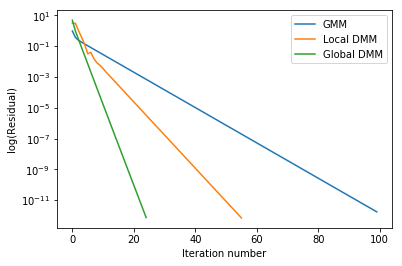

In [14]:
plt.semilogy(linear_gmg.get_gmg_convergence(),label = 'GMM')
plt.semilogy(deep_gmm.get_gmg_convergence(),label= 'Local DMM')
plt.semilogy(DMM_Res,label= 'Global DMM')
plt.xlabel("Iteration number")
plt.ylabel("log(Residual)")
plt.legend()